In [1]:
# 基本庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

# Darts - 時間序列相關庫
import darts
from darts import TimeSeries, concatenate
from darts.models import (
    DLinearModel, LightGBMModel, BlockRNNModel, TiDEModel, 
    Prophet, AutoARIMA, ARIMA
)
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics.metrics import mape, mae, mse, ape
from darts.logging import get_logger, raise_log, raise_if_not

# Scikit-learn - 數據預處理
from sklearn.preprocessing import MinMaxScaler
from tools.callbacks import LossLoggingCallback
from tools.calculate_95_ci import calculate_95_ci
from tools.calculate_metrics import calculate_metrics
from tools.data_loader import load_and_preprocess_data

import torch
import torch.optim as optim

In [2]:
print(torch.cuda.is_available())  # 如果結果是 True，表示 GPU 可用

True


In [3]:
location = 'Taipei' 
model_type = 'TiDE' 
location_params = {
    'Linkou': {'train_end': 3362, 'val_end': 3727},
    'Taipei': {'train_end': 3372, 'val_end': 3737},
    'Kaohsiung': {'train_end': 3208, 'val_end': 3573},
    'Keelung': {'train_end': 3274, 'val_end': 3639},
    'Yunlin': {'train_end': 2557, 'val_end': 2922},
    'Chiayi': {'train_end': 3237, 'val_end': 3602}
}

#Data preprocess

In [5]:
train_series_scaled, test_series_scaled, combined_series_scaled, train_series, test_series, combined_series, ED_covariates, scaler = load_and_preprocess_data(location)

#Model

In [7]:
loss_logging_callback = LossLoggingCallback()
model = TiDEModel(
    input_chunk_length=30,
    output_chunk_length=7,
    log_tensorboard=True,
    hidden_size=24, 
    optimizer_cls=optim.Adam,  # 使用 Adam 优化器
    optimizer_kwargs={"lr": 0.0018988571112406572}, 
    num_encoder_layers=4, 
    num_decoder_layers=1, 
    dropout=0.0029073196599621286,
    batch_size=128,
    save_checkpoints=True,
    pl_trainer_kwargs = {
    "max_epochs": 15,
    "accelerator": "gpu",  # 使用 GPU
    "devices": [0],  # 指定 GPU 設備
    "callbacks": [loss_logging_callback ]},)

In [8]:
forecast_horizon =7        
retrain = 1
stride = 7
train_length = location_params[location]['train_end']

# Assuming 'test_series' and 'ED_covariates' are properly defined Darts TimeSeries objects
# Perform the historical forecast
backtest_series = model.historical_forecasts(
    series=combined_series_scaled,
    past_covariates=ED_covariates,
    forecast_horizon=forecast_horizon,
    stride=stride,
    retrain=retrain,
    start=pd.Timestamp('2018-01-01'),
    train_length = train_length,
    verbose=True,
    last_points_only=False,
)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/247 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0080035848329296


C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:384: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?


Epoch 1: train_loss=0.008413203062147207
Epoch 2: train_loss=0.008366316926858366
Epoch 3: train_loss=0.001984314938850921
Epoch 4: train_loss=0.0018280674013585014
Epoch 5: train_loss=0.002922310427388713
Epoch 6: train_loss=0.0034845208223397567
Epoch 7: train_loss=0.0030448067425010894
Epoch 8: train_loss=0.0027652278256562884
Epoch 9: train_loss=0.003525586379328631
Epoch 10: train_loss=0.0029392823406180005
Epoch 11: train_loss=0.0027210289834163986
Epoch 12: train_loss=0.002194673370010673
Epoch 13: train_loss=0.003497014012022797


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.010701905355118916


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.029733041991546603
Epoch 1: train_loss=0.003255869477275297
Epoch 2: train_loss=0.0037581089758921943
Epoch 3: train_loss=0.003936880015266307
Epoch 4: train_loss=0.004907706974190966
Epoch 5: train_loss=0.004685458802462045
Epoch 6: train_loss=0.0022843153195828904
Epoch 7: train_loss=0.004559451120807123
Epoch 8: train_loss=0.0036395777992507053
Epoch 9: train_loss=0.0022663568644358356
Epoch 10: train_loss=0.005571893790903434
Epoch 11: train_loss=0.0021570879591962995
Epoch 12: train_loss=0.0023502848685725084
Epoch 13: train_loss=0.0016459908943391513


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0031910774786495376


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0058167629748595365
Epoch 1: train_loss=0.007075539502680948
Epoch 2: train_loss=0.005070871548145762
Epoch 3: train_loss=0.0071603044900203725
Epoch 4: train_loss=0.004264635246783823
Epoch 5: train_loss=0.003963830452027398
Epoch 6: train_loss=0.003862694708496728
Epoch 7: train_loss=0.002168109956087436
Epoch 8: train_loss=0.0017290370396563389
Epoch 9: train_loss=0.0014627484423527168
Epoch 10: train_loss=0.0024465104051159866
Epoch 11: train_loss=0.0015559724095396514
Epoch 12: train_loss=0.0021152066055356877
Epoch 13: train_loss=0.001949328831567821


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002491121346038747


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.031827958103826215
Epoch 1: train_loss=0.00405231168703599
Epoch 2: train_loss=0.00483066569726034
Epoch 3: train_loss=0.015465107188361266
Epoch 4: train_loss=0.004334095054262782
Epoch 5: train_loss=0.0021963467876719464
Epoch 6: train_loss=0.002801634700499357
Epoch 7: train_loss=0.004079456011736519
Epoch 8: train_loss=0.00234547179133435
Epoch 9: train_loss=0.0036753407789015067
Epoch 10: train_loss=0.002214616146142766
Epoch 11: train_loss=0.0020959763677513535
Epoch 12: train_loss=0.0031417127420811774
Epoch 13: train_loss=0.01408025384406358


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0027825098414694196


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006809249514901093
Epoch 1: train_loss=0.007102907543623485
Epoch 2: train_loss=0.006844998292145836
Epoch 3: train_loss=0.002305482903016119
Epoch 4: train_loss=0.002708871159084869
Epoch 5: train_loss=0.003498741264456767
Epoch 6: train_loss=0.006289036609677612
Epoch 7: train_loss=0.002268274341527759
Epoch 8: train_loss=0.002704684757179303
Epoch 9: train_loss=0.0024490624050728287
Epoch 10: train_loss=0.0024854359592113907
Epoch 11: train_loss=0.0032349034645721584
Epoch 12: train_loss=0.0028768226432702645
Epoch 13: train_loss=0.002572179138945021


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0026861260868465075


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00799617443907935
Epoch 1: train_loss=0.00446757745615903
Epoch 2: train_loss=0.0031067155001863102
Epoch 3: train_loss=0.008202465720650106
Epoch 4: train_loss=0.002058724197762874
Epoch 5: train_loss=0.0035121257466054255
Epoch 6: train_loss=0.0028030895318292407
Epoch 7: train_loss=0.015780858084657515
Epoch 8: train_loss=0.0019672238938063017
Epoch 9: train_loss=0.0019448705660122343
Epoch 10: train_loss=0.0036349998256364133
Epoch 11: train_loss=0.0026935855480151104
Epoch 12: train_loss=0.004232497343228229
Epoch 13: train_loss=0.0029365206087136357


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002954984875709243


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011217962714270942
Epoch 1: train_loss=0.03410862747737132
Epoch 2: train_loss=0.0035570470335902025
Epoch 3: train_loss=0.002930016870037959
Epoch 4: train_loss=0.004020020520795257
Epoch 5: train_loss=0.008467209590876858
Epoch 6: train_loss=0.0038295216643279774
Epoch 7: train_loss=0.0016669098398373109
Epoch 8: train_loss=0.0014854123159412428
Epoch 9: train_loss=0.0032582016845356804
Epoch 10: train_loss=0.0025121901401324587
Epoch 11: train_loss=0.002708729492110862
Epoch 12: train_loss=0.010633275392030773
Epoch 13: train_loss=0.0014092926938760256


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.017867266243318174


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0031344813351888512
Epoch 1: train_loss=0.0027421556319797385
Epoch 2: train_loss=0.006286515694594245
Epoch 3: train_loss=0.0029707839569223975
Epoch 4: train_loss=0.002302953563206902
Epoch 5: train_loss=0.00451892231968262
Epoch 6: train_loss=0.008765132453866287
Epoch 7: train_loss=0.005165301922190478
Epoch 8: train_loss=0.007040581835989573
Epoch 9: train_loss=0.013554491469367328
Epoch 10: train_loss=0.00390541610518223
Epoch 11: train_loss=0.00354291827834649
Epoch 12: train_loss=0.0015657660507936452
Epoch 13: train_loss=0.0026848936830259013


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022031774357789365


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007113888555509785
Epoch 1: train_loss=0.00241746564866728
Epoch 2: train_loss=0.011192287804681515
Epoch 3: train_loss=0.006071925943302044
Epoch 4: train_loss=0.0021667322365659146
Epoch 5: train_loss=0.004882449063802159
Epoch 6: train_loss=0.001997687863354014
Epoch 7: train_loss=0.00230386302178002
Epoch 8: train_loss=0.01174723539802522
Epoch 9: train_loss=0.0021541916903645843
Epoch 10: train_loss=0.0031649691999131803
Epoch 11: train_loss=0.005100406904442879
Epoch 12: train_loss=0.006898864402274543
Epoch 13: train_loss=0.003012712016217147


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0020443122528841866


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.016926203325737837
Epoch 1: train_loss=0.01333378405478019
Epoch 2: train_loss=0.006954300074463877
Epoch 3: train_loss=0.002793987229766396
Epoch 4: train_loss=0.004661868622251238
Epoch 5: train_loss=0.005574643327814827
Epoch 6: train_loss=0.002322433931309834
Epoch 7: train_loss=0.010795104147269063
Epoch 8: train_loss=0.0014562657422575224
Epoch 9: train_loss=0.0022158463906576205
Epoch 10: train_loss=0.0018430472543630463
Epoch 11: train_loss=0.0020194826059576477
Epoch 12: train_loss=0.0029448946989971006
Epoch 13: train_loss=0.0018977460545924322


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0037689821773711097


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004582561462577353
Epoch 1: train_loss=0.0029856699837068987
Epoch 2: train_loss=0.00402165551492966
Epoch 3: train_loss=0.022652362133135578
Epoch 4: train_loss=0.0030483734638732858
Epoch 5: train_loss=0.0028584765524219146
Epoch 6: train_loss=0.0023282444600674027
Epoch 7: train_loss=0.00176170013699882
Epoch 8: train_loss=0.0031187195519041208
Epoch 9: train_loss=0.003183751866015927
Epoch 10: train_loss=0.002216978104413322
Epoch 11: train_loss=0.0057204469893627225
Epoch 12: train_loss=0.00218745816938516
Epoch 13: train_loss=0.0030650925190241415


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00278091288032594


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.01785103473785637
Epoch 1: train_loss=0.004065934355612926
Epoch 2: train_loss=0.006995563857323991
Epoch 3: train_loss=0.0021032692934909547
Epoch 4: train_loss=0.0031341476571678227
Epoch 5: train_loss=0.004003664047917795
Epoch 6: train_loss=0.004606907638276779
Epoch 7: train_loss=0.002668996669496
Epoch 8: train_loss=0.007772075277136152
Epoch 9: train_loss=0.0020327650605883297
Epoch 10: train_loss=0.002531281856744347
Epoch 11: train_loss=0.0026054302719418047
Epoch 12: train_loss=0.007300948012905206
Epoch 13: train_loss=0.002206032964128069


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0020142373256590716


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005175724744135218
Epoch 1: train_loss=0.0028402986443503476
Epoch 2: train_loss=0.0033702473761234725
Epoch 3: train_loss=0.005231338318089434
Epoch 4: train_loss=0.0030007729366667755
Epoch 5: train_loss=0.0022796481911757827
Epoch 6: train_loss=0.00326290527049015
Epoch 7: train_loss=0.002061576642444432
Epoch 8: train_loss=0.002836173559163154
Epoch 9: train_loss=0.0030283317015434236
Epoch 10: train_loss=0.0020468724021746334
Epoch 11: train_loss=0.001689517375868981
Epoch 12: train_loss=0.0028429421894634994
Epoch 13: train_loss=0.00252917399009394


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022089943806962286


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009303149278061381
Epoch 1: train_loss=0.009144063474317975
Epoch 2: train_loss=0.003934165979172135
Epoch 3: train_loss=0.017078175973346075
Epoch 4: train_loss=0.007605261541775434
Epoch 5: train_loss=0.002701541202279422
Epoch 6: train_loss=0.0038425496763834005
Epoch 7: train_loss=0.0018336873507653973
Epoch 8: train_loss=0.00149569631766693
Epoch 9: train_loss=0.0028010476036454037
Epoch 10: train_loss=0.0015331212230900368
Epoch 11: train_loss=0.007261665391916584
Epoch 12: train_loss=0.002579308918530667
Epoch 13: train_loss=0.0021858513343629535


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017308866629755968


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0076418380333710696
Epoch 1: train_loss=0.00404413764582642
Epoch 2: train_loss=0.0030109631383769373
Epoch 3: train_loss=0.00631393210781922
Epoch 4: train_loss=0.0036110443383646903
Epoch 5: train_loss=0.0024519876021356153
Epoch 6: train_loss=0.008881790198841064
Epoch 7: train_loss=0.002762527996916408
Epoch 8: train_loss=0.0019221780920780068
Epoch 9: train_loss=0.0022104468683829116
Epoch 10: train_loss=0.002286345831713515
Epoch 11: train_loss=0.0016075673490544631
Epoch 12: train_loss=0.0021380738197723692
Epoch 13: train_loss=0.004312538449640559


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002070457842996384


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009079307024337756
Epoch 1: train_loss=0.004739189624509543
Epoch 2: train_loss=0.004409705340995818
Epoch 3: train_loss=0.004844324025389989
Epoch 4: train_loss=0.0017583818555264752
Epoch 5: train_loss=0.002015311428525502
Epoch 6: train_loss=0.00434546726295772
Epoch 7: train_loss=0.0032969150897817746
Epoch 8: train_loss=0.0030251167512505847
Epoch 9: train_loss=0.0023541582251974803
Epoch 10: train_loss=0.004004859900354891
Epoch 11: train_loss=0.002673182304046517
Epoch 12: train_loss=0.0032661313305397768
Epoch 13: train_loss=0.0023715684539301176


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016385228059505633


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008398148473761413
Epoch 1: train_loss=0.004773551783601518
Epoch 2: train_loss=0.0028076826125417046
Epoch 3: train_loss=0.020766848672521803
Epoch 4: train_loss=0.01756648522697941
Epoch 5: train_loss=0.0013476425944733963
Epoch 6: train_loss=0.004646516702167543
Epoch 7: train_loss=0.0011889619649012282
Epoch 8: train_loss=0.004108453369972038
Epoch 9: train_loss=0.002482871353744654
Epoch 10: train_loss=0.0025287759608326496
Epoch 11: train_loss=0.0024058925817747718
Epoch 12: train_loss=0.0023664743707873213
Epoch 13: train_loss=0.0043779122101674445


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0020762944687982518


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007741956403721645
Epoch 1: train_loss=0.008301599468569903
Epoch 2: train_loss=0.006067002075872915
Epoch 3: train_loss=0.004809736314325069
Epoch 4: train_loss=0.0035492389132799488
Epoch 5: train_loss=0.0025516639067155707
Epoch 6: train_loss=0.002601714299953628
Epoch 7: train_loss=0.0034508755367422764
Epoch 8: train_loss=0.0018587842967410732
Epoch 9: train_loss=0.0027585931796629943
Epoch 10: train_loss=0.0023761983155895904
Epoch 11: train_loss=0.004447695118838644
Epoch 12: train_loss=0.005346524850018731
Epoch 13: train_loss=0.002486267599335763


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004361434568227462


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011196749585715876
Epoch 1: train_loss=0.00636504313651246
Epoch 2: train_loss=0.0064089473156380035
Epoch 3: train_loss=0.0046509916705263195
Epoch 4: train_loss=0.00295970385776304
Epoch 5: train_loss=0.002983981808584038
Epoch 6: train_loss=0.003130246611443068
Epoch 7: train_loss=0.0029118740768629015
Epoch 8: train_loss=0.003327469828274706
Epoch 9: train_loss=0.004058601516152119
Epoch 10: train_loss=0.002464921826714
Epoch 11: train_loss=0.0043099555686419815
Epoch 12: train_loss=0.003015620561986973
Epoch 13: train_loss=0.002213507470451948


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021213734250455463


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004782046671225816
Epoch 1: train_loss=0.0033081932949807677
Epoch 2: train_loss=0.0028166725230958922
Epoch 3: train_loss=0.0016246935731213587
Epoch 4: train_loss=0.0026076204938617837
Epoch 5: train_loss=0.0032852544263946197
Epoch 6: train_loss=0.0034826074375487338
Epoch 7: train_loss=0.003059276765323973
Epoch 8: train_loss=0.004251094429592049
Epoch 9: train_loss=0.007672260714582501
Epoch 10: train_loss=0.0019194590713584594
Epoch 11: train_loss=0.0026213538009125133
Epoch 12: train_loss=0.002207655541785267
Epoch 13: train_loss=0.002054218018156071


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0027494418396058792


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007603491103571783
Epoch 1: train_loss=0.006615580438450733
Epoch 2: train_loss=0.003233199827107681
Epoch 3: train_loss=0.005634525083451499
Epoch 4: train_loss=0.0018526837946674273
Epoch 5: train_loss=0.009469173732329313
Epoch 6: train_loss=0.010001757208641595
Epoch 7: train_loss=0.0036331187229280606
Epoch 8: train_loss=0.001958668613061526
Epoch 9: train_loss=0.0022411139238779176
Epoch 10: train_loss=0.002132928673797672
Epoch 11: train_loss=0.0029291632016671585
Epoch 12: train_loss=0.0021258506773929975
Epoch 13: train_loss=0.0016584509898320346


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True


Epoch 14: train_loss=0.002048691534643503


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004894870517755144
Epoch 1: train_loss=0.0032077031978774793
Epoch 2: train_loss=0.004136314051341287
Epoch 3: train_loss=0.005595203117770367
Epoch 4: train_loss=0.0031108684368635993
Epoch 5: train_loss=0.0046503266171809094
Epoch 6: train_loss=0.004097121330917786
Epoch 7: train_loss=0.003940021137376622
Epoch 8: train_loss=0.004296475208158246
Epoch 9: train_loss=0.0022692349688868837
Epoch 10: train_loss=0.0034330826244961974
Epoch 11: train_loss=0.003054659557356595
Epoch 12: train_loss=0.003393064956084862
Epoch 13: train_loss=0.0014235406567162788


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004531173163455695


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007768428233463925
Epoch 1: train_loss=0.027953504195990263
Epoch 2: train_loss=0.011744734376411187
Epoch 3: train_loss=0.003982055860276557
Epoch 4: train_loss=0.003432830596110772
Epoch 5: train_loss=0.0028276361884208862
Epoch 6: train_loss=0.0034449582636616786
Epoch 7: train_loss=0.002511244875591828
Epoch 8: train_loss=0.007774706367193081
Epoch 9: train_loss=0.0023551887690875417
Epoch 10: train_loss=0.004739094165821305
Epoch 11: train_loss=0.002746441562012732
Epoch 12: train_loss=0.0016679571158732813
Epoch 13: train_loss=0.003313890512253573


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002580570428007311


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0052680938648985215
Epoch 1: train_loss=0.005820985001535837
Epoch 2: train_loss=0.003174778123746265
Epoch 3: train_loss=0.004085686739656736
Epoch 4: train_loss=0.004427992784342855
Epoch 5: train_loss=0.003300675049504552
Epoch 6: train_loss=0.002055958350874324
Epoch 7: train_loss=0.0019887099617432596
Epoch 8: train_loss=0.0031499459382733877
Epoch 9: train_loss=0.004279913472350089
Epoch 10: train_loss=0.0016058915356488056
Epoch 11: train_loss=0.0028241824222177084
Epoch 12: train_loss=0.0037015851904333135
Epoch 13: train_loss=0.0030861638534206105


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002334214805443037


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007407973447355526
Epoch 1: train_loss=0.008624197481555192
Epoch 2: train_loss=0.00396556568783904
Epoch 3: train_loss=0.0038953208582004754
Epoch 4: train_loss=0.002108091216037271
Epoch 5: train_loss=0.003119337818951664
Epoch 6: train_loss=0.0032513141045647388
Epoch 7: train_loss=0.001927667606233574
Epoch 8: train_loss=0.0035237367080349384
Epoch 9: train_loss=0.0037499081326031795
Epoch 10: train_loss=0.002371907049369086
Epoch 11: train_loss=0.0024144091040323684
Epoch 12: train_loss=0.0027578247076555083
Epoch 13: train_loss=0.002385181287281065


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003295384435140163


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.012250394947942911
Epoch 1: train_loss=0.005861465658103693
Epoch 2: train_loss=0.0032300375560183076
Epoch 3: train_loss=0.005331985809063088
Epoch 4: train_loss=0.004246152619702723
Epoch 5: train_loss=0.00227906110866583
Epoch 6: train_loss=0.0012480484693966046
Epoch 7: train_loss=0.0034660328218386613
Epoch 8: train_loss=0.0029998015215566623
Epoch 9: train_loss=0.0024171585692902594
Epoch 10: train_loss=0.004290799923650328
Epoch 11: train_loss=0.003032124027917913
Epoch 12: train_loss=0.005380256414724332
Epoch 13: train_loss=0.004838154863422979


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0027222998197503146


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.010106026696029356
Epoch 1: train_loss=0.0037435851032323933
Epoch 2: train_loss=0.0019429559997871271
Epoch 3: train_loss=0.005424534782843483
Epoch 4: train_loss=0.0029958953164691826
Epoch 5: train_loss=0.002440141991887737
Epoch 6: train_loss=0.0015794063647417184
Epoch 7: train_loss=0.0072540179752773205
Epoch 8: train_loss=0.0020399336980941756
Epoch 9: train_loss=0.0024467437491880817
Epoch 10: train_loss=0.0015568639248039248
Epoch 11: train_loss=0.0022424374217273006
Epoch 12: train_loss=0.0016873255108042409
Epoch 13: train_loss=0.0018976221808003244


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0029526057421741135


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004562062299452834
Epoch 1: train_loss=0.005623488024992159
Epoch 2: train_loss=0.006273085507816969
Epoch 3: train_loss=0.00455104647671202
Epoch 4: train_loss=0.0025876473582730863
Epoch 5: train_loss=0.0034167495876626748
Epoch 6: train_loss=0.0022125357426585907
Epoch 7: train_loss=0.0024264224925477523
Epoch 8: train_loss=0.0017130155421014213
Epoch 9: train_loss=0.001994642593685609
Epoch 10: train_loss=0.0024152942047499892
Epoch 11: train_loss=0.001976606461627707
Epoch 12: train_loss=0.008030090406760042
Epoch 13: train_loss=0.0015111275692285572


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0036840295871973525


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007982245262774084
Epoch 1: train_loss=0.007547489789409897
Epoch 2: train_loss=0.009278556780056587
Epoch 3: train_loss=0.002911965477360713
Epoch 4: train_loss=0.002484044469920349
Epoch 5: train_loss=0.0018156059123062532
Epoch 6: train_loss=0.003999759780210618
Epoch 7: train_loss=0.0030896783141006177
Epoch 8: train_loss=0.002574630684587699
Epoch 9: train_loss=0.002589528759916534
Epoch 10: train_loss=0.003662215922382865
Epoch 11: train_loss=0.0018906802653239267
Epoch 12: train_loss=0.0035288282734185815
Epoch 13: train_loss=0.0035028458312046226


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0033449905993324348


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006892624927370917
Epoch 1: train_loss=0.0081765731367405
Epoch 2: train_loss=0.0021654580357659387
Epoch 3: train_loss=0.00633265187400289
Epoch 4: train_loss=0.004943572896141824
Epoch 5: train_loss=0.004021072259399345
Epoch 6: train_loss=0.004850489286457975
Epoch 7: train_loss=0.003791320773072616
Epoch 8: train_loss=0.0025133183340013488
Epoch 9: train_loss=0.003157600834034323
Epoch 10: train_loss=0.003282697361053168
Epoch 11: train_loss=0.0021397654459085363
Epoch 12: train_loss=0.0033379925072521913
Epoch 13: train_loss=0.0024609943254579885


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0051929174301359755


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006203318944560579
Epoch 1: train_loss=0.0029907874979420404
Epoch 2: train_loss=0.005725624837103358
Epoch 3: train_loss=0.003621756231364127
Epoch 4: train_loss=0.004101715413166296
Epoch 5: train_loss=0.004441442070325239
Epoch 6: train_loss=0.002297643780826529
Epoch 7: train_loss=0.002223918280004705
Epoch 8: train_loss=0.002397337458031176
Epoch 9: train_loss=0.001774443714398125
Epoch 10: train_loss=0.003959067278399844
Epoch 11: train_loss=0.00258875909706825
Epoch 12: train_loss=0.005440760094692555
Epoch 13: train_loss=0.00171112321499003


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00633518253507864


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.010155500816056219
Epoch 1: train_loss=0.007063874266759479
Epoch 2: train_loss=0.004367152453863083
Epoch 3: train_loss=0.0026978651095800805
Epoch 4: train_loss=0.0174888645654203
Epoch 5: train_loss=0.0026378762761336497
Epoch 6: train_loss=0.0037077388161362666
Epoch 7: train_loss=0.011996977635147515
Epoch 8: train_loss=0.002921765661992595
Epoch 9: train_loss=0.0024529530759289414
Epoch 10: train_loss=0.003380817277143007
Epoch 11: train_loss=0.0069985242447360985
Epoch 12: train_loss=0.0019022972189724717
Epoch 13: train_loss=0.0031206784891256506


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00452484352517035


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.015023997408376838
Epoch 1: train_loss=0.020239952500186214
Epoch 2: train_loss=0.004615844169935194
Epoch 3: train_loss=0.027506629554901452
Epoch 4: train_loss=0.004935634422349501
Epoch 5: train_loss=0.002160381655555585
Epoch 6: train_loss=0.0022231675691702954
Epoch 7: train_loss=0.002978670676011637
Epoch 8: train_loss=0.002455701886246479
Epoch 9: train_loss=0.00462424812538348
Epoch 10: train_loss=0.001653979058018329
Epoch 11: train_loss=0.002086586880029292
Epoch 12: train_loss=0.0025432143219306248
Epoch 13: train_loss=0.0027420647351857233


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0026300927759448514


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.018954718836175343
Epoch 1: train_loss=0.04537365129269896
Epoch 2: train_loss=0.003922399406350018
Epoch 3: train_loss=0.0028397855352406695
Epoch 4: train_loss=0.0047927735431502715
Epoch 5: train_loss=0.0017109397790278373
Epoch 6: train_loss=0.002314462816638494
Epoch 7: train_loss=0.005848190978278246
Epoch 8: train_loss=0.0018745792337178859
Epoch 9: train_loss=0.004626084675379022
Epoch 10: train_loss=0.003024012999905146
Epoch 11: train_loss=0.0022766215392863638
Epoch 12: train_loss=0.0035297974122815347
Epoch 13: train_loss=0.014607926485418272


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004084237001635294


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.025143769828006184
Epoch 1: train_loss=0.003423411038129015
Epoch 2: train_loss=0.002513557063920401
Epoch 3: train_loss=0.0022201206983935165
Epoch 4: train_loss=0.0025167716422561737
Epoch 5: train_loss=0.003185216660680364
Epoch 6: train_loss=0.01004594600015297
Epoch 7: train_loss=0.0017245073006681843
Epoch 8: train_loss=0.0028111640018027434
Epoch 9: train_loss=0.003402995384509317
Epoch 10: train_loss=0.002731674368630858
Epoch 11: train_loss=0.002166321600052563
Epoch 12: train_loss=0.0022062174907270457
Epoch 13: train_loss=0.0019306889718827655


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0033223784118694877


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006716125113126581
Epoch 1: train_loss=0.01178458211006117
Epoch 2: train_loss=0.01095728669356169
Epoch 3: train_loss=0.00531459586082086
Epoch 4: train_loss=0.003162541400352926
Epoch 5: train_loss=0.0027416271312886427
Epoch 6: train_loss=0.008044208454570335
Epoch 7: train_loss=0.002509312810917063
Epoch 8: train_loss=0.002972471701027173
Epoch 9: train_loss=0.003669614923952681
Epoch 10: train_loss=0.0023980106619824943
Epoch 11: train_loss=0.006954726382001803
Epoch 12: train_loss=0.002486502760387399
Epoch 13: train_loss=0.001736978282823201


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025608709235046567


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008169046335666461
Epoch 1: train_loss=0.00515341886797552
Epoch 2: train_loss=0.029068122061972887
Epoch 3: train_loss=0.0022625988239055833
Epoch 4: train_loss=0.00360960324778512
Epoch 5: train_loss=0.004044633961732629
Epoch 6: train_loss=0.0025389076719829454
Epoch 7: train_loss=0.0037142741664561688
Epoch 8: train_loss=0.00205459328554486
Epoch 9: train_loss=0.0018208586065613964
Epoch 10: train_loss=0.0037819301501533092
Epoch 11: train_loss=0.004119747241882855
Epoch 12: train_loss=0.008894034974006362
Epoch 13: train_loss=0.00905061520156779


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00136947623246474


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00535592300438287
Epoch 1: train_loss=0.003826705015091953
Epoch 2: train_loss=0.010200034197274714
Epoch 3: train_loss=0.0027555574650655747
Epoch 4: train_loss=0.004120032469388311
Epoch 5: train_loss=0.0027798293154511944
Epoch 6: train_loss=0.002433435609300224
Epoch 7: train_loss=0.0025642014316142603
Epoch 8: train_loss=0.0030011750243616165
Epoch 9: train_loss=0.004798527498780851
Epoch 10: train_loss=0.007119313473679816
Epoch 11: train_loss=0.0017197465638467274
Epoch 12: train_loss=0.0020792216738682815
Epoch 13: train_loss=0.0017102432862253615


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003716099498451829


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009447943403518129
Epoch 1: train_loss=0.010342033261505979
Epoch 2: train_loss=0.00505005136281177
Epoch 3: train_loss=0.002016459067534801
Epoch 4: train_loss=0.0032784326546830504
Epoch 5: train_loss=0.0025801740761596174
Epoch 6: train_loss=0.0033480868499521682
Epoch 7: train_loss=0.0026738012634263367
Epoch 8: train_loss=0.002678300114077358
Epoch 9: train_loss=0.003787784382502738
Epoch 10: train_loss=0.002789143818438904
Epoch 11: train_loss=0.0024053107469039787
Epoch 12: train_loss=0.004612696013730199
Epoch 13: train_loss=0.0033043130364859463


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001537771763710297


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.01184268630400813
Epoch 1: train_loss=0.0029857086725304694
Epoch 2: train_loss=0.0033186079032645594
Epoch 3: train_loss=0.0021434951749486654
Epoch 4: train_loss=0.002599954289658068
Epoch 5: train_loss=0.002795931814601789
Epoch 6: train_loss=0.002666859704172687
Epoch 7: train_loss=0.0026558328133615555
Epoch 8: train_loss=0.002672901951217775
Epoch 9: train_loss=0.016871050526552314
Epoch 10: train_loss=0.0038054614095583464
Epoch 11: train_loss=0.0022493507941683173
Epoch 12: train_loss=0.0034473977013724636
Epoch 13: train_loss=0.0030431476705435976


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002478968711601641


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009543723206676782
Epoch 1: train_loss=0.0026578928655395903
Epoch 2: train_loss=0.004562107625524194
Epoch 3: train_loss=0.002777794927694648
Epoch 4: train_loss=0.002479274838028987
Epoch 5: train_loss=0.004911521188465038
Epoch 6: train_loss=0.0030745309342170763
Epoch 7: train_loss=0.0042512908389233245
Epoch 8: train_loss=0.001746203959185556
Epoch 9: train_loss=0.0035364149280856
Epoch 10: train_loss=0.002236914745996616
Epoch 11: train_loss=0.0016972636925153242
Epoch 12: train_loss=0.003334626906292243
Epoch 13: train_loss=0.002742080824793541


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002187988808873958


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.012698906519685731
Epoch 1: train_loss=0.003766892241746099
Epoch 2: train_loss=0.0027404268884897265
Epoch 3: train_loss=0.0028581764206732927
Epoch 4: train_loss=0.003355142452986107
Epoch 5: train_loss=0.0034112403108424788
Epoch 6: train_loss=0.001842600785060059
Epoch 7: train_loss=0.002883052093671058
Epoch 8: train_loss=0.001365459512924832
Epoch 9: train_loss=0.0027660952867106406
Epoch 10: train_loss=0.01855726843452168
Epoch 11: train_loss=0.0020378089163589235
Epoch 12: train_loss=0.001180337984621289
Epoch 13: train_loss=0.003762183142579161


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002840746536175915


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008563710093225185
Epoch 1: train_loss=0.003689309472086183
Epoch 2: train_loss=0.0016868149313559444
Epoch 3: train_loss=0.004007649029520895
Epoch 4: train_loss=0.0032064776434031117
Epoch 5: train_loss=0.0032414179409769924
Epoch 6: train_loss=0.002732104299458142
Epoch 7: train_loss=0.002719839255314528
Epoch 8: train_loss=0.0024288596146963396
Epoch 9: train_loss=0.0016431654355545458
Epoch 10: train_loss=0.0015349555519487575
Epoch 11: train_loss=0.0022905891707315526
Epoch 12: train_loss=0.0022871582693808493
Epoch 13: train_loss=0.0024855412812429885


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.005155636733242147


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00771706172389533
Epoch 1: train_loss=0.005170307044239742
Epoch 2: train_loss=0.004837328586329465
Epoch 3: train_loss=0.003421598911859431
Epoch 4: train_loss=0.0020702265531908574
Epoch 5: train_loss=0.005173472922219472
Epoch 6: train_loss=0.003346902230112464
Epoch 7: train_loss=0.0035767651586815683
Epoch 8: train_loss=0.02561901337336729
Epoch 9: train_loss=0.004013672643339789
Epoch 10: train_loss=0.0056672642898320845
Epoch 11: train_loss=0.0029410611382953773
Epoch 12: train_loss=0.003614104026276253
Epoch 13: train_loss=0.00155850551552217


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.010966672326736551


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004683518832484155
Epoch 1: train_loss=0.010154824678485637
Epoch 2: train_loss=0.0056719075663287846
Epoch 3: train_loss=0.0033055562166437805
Epoch 4: train_loss=0.0044829758567050855
Epoch 5: train_loss=0.003059144259622404
Epoch 6: train_loss=0.0025392863797425538
Epoch 7: train_loss=0.0029278492166948653
Epoch 8: train_loss=0.002194510697757178
Epoch 9: train_loss=0.0025148741000729914
Epoch 10: train_loss=0.0019205958401902533
Epoch 11: train_loss=0.008681626959445814
Epoch 12: train_loss=0.002997485741222275
Epoch 13: train_loss=0.0020248995708064617


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0026332209890547196


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.032101020674032546
Epoch 1: train_loss=0.004570558004905848
Epoch 2: train_loss=0.004367843184331748
Epoch 3: train_loss=0.005996900134938854
Epoch 4: train_loss=0.001497828153633518
Epoch 5: train_loss=0.0031634401358287866
Epoch 6: train_loss=0.002036666371289894
Epoch 7: train_loss=0.0028135733658625275
Epoch 8: train_loss=0.0017366681639753433
Epoch 9: train_loss=0.0022591678386165953
Epoch 10: train_loss=0.0014599376353404698
Epoch 11: train_loss=0.0026582171780024197
Epoch 12: train_loss=0.003300971944980928
Epoch 13: train_loss=0.0039461482316406815


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001617324376538549


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0070646655058751945
Epoch 1: train_loss=0.02063020846299
Epoch 2: train_loss=0.0033024720019042145
Epoch 3: train_loss=0.001852204024752907
Epoch 4: train_loss=0.008635330881910432
Epoch 5: train_loss=0.002668562447025242
Epoch 6: train_loss=0.0033095735224250833
Epoch 7: train_loss=0.003922672099639627
Epoch 8: train_loss=0.0025498850959258163
Epoch 9: train_loss=0.004891677043377176
Epoch 10: train_loss=0.0025450645446018997
Epoch 11: train_loss=0.0021676093200922136
Epoch 12: train_loss=0.0024772770423890722
Epoch 13: train_loss=0.001981129861328885


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004178189210067464


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00621509052761164
Epoch 1: train_loss=0.004351179408320487
Epoch 2: train_loss=0.005108878587385759
Epoch 3: train_loss=0.024580767580169825
Epoch 4: train_loss=0.0031565219917694997
Epoch 5: train_loss=0.0018853207127538054
Epoch 6: train_loss=0.0019436883402289959
Epoch 7: train_loss=0.005301689637371526
Epoch 8: train_loss=0.0016403458222383704
Epoch 9: train_loss=0.0021237405658156073
Epoch 10: train_loss=0.0052920747593968595
Epoch 11: train_loss=0.0054433644994266025
Epoch 12: train_loss=0.0031488698211370016
Epoch 13: train_loss=0.0023081487804210393


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0020613116302665557


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004706590413989397
Epoch 1: train_loss=0.003816354166744182
Epoch 2: train_loss=0.004088144393986392
Epoch 3: train_loss=0.0033838390718804357
Epoch 4: train_loss=0.0025198740985082854
Epoch 5: train_loss=0.004493905004383428
Epoch 6: train_loss=0.011818017249383366
Epoch 7: train_loss=0.0017650920811147224
Epoch 8: train_loss=0.003034610361122695
Epoch 9: train_loss=0.002963575153276221
Epoch 10: train_loss=0.001826941781966375
Epoch 11: train_loss=0.005279259317421698
Epoch 12: train_loss=0.003574103249719123
Epoch 13: train_loss=0.00209768873549385


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016993366430251569


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004477212441521811
Epoch 1: train_loss=0.0029224922056756823
Epoch 2: train_loss=0.0030273292390952866
Epoch 3: train_loss=0.0017136722221209985
Epoch 4: train_loss=0.0032174348516618412
Epoch 5: train_loss=0.0026992619161823593
Epoch 6: train_loss=0.0025509418033084156
Epoch 7: train_loss=0.0023576948100512136
Epoch 8: train_loss=0.0036851073215919405
Epoch 9: train_loss=0.001936804271638681
Epoch 10: train_loss=0.0021944315668012055
Epoch 11: train_loss=0.0024923286587468195
Epoch 12: train_loss=0.0030438992508769595
Epoch 13: train_loss=0.0017548114574335726


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0031124110297518328


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.01658054816775992
Epoch 1: train_loss=0.002802256532419321
Epoch 2: train_loss=0.005712654955195418
Epoch 3: train_loss=0.003353227300204188
Epoch 4: train_loss=0.005037603213022131
Epoch 5: train_loss=0.030123762130593812
Epoch 6: train_loss=0.002575625588986639
Epoch 7: train_loss=0.0025898305271488302
Epoch 8: train_loss=0.0024870634600497876
Epoch 9: train_loss=0.004876523615673515
Epoch 10: train_loss=0.002561685335877172
Epoch 11: train_loss=0.0018044222688501828
Epoch 12: train_loss=0.007191398876319151
Epoch 13: train_loss=0.002502121755892224


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0030956339218523917


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0068592600063009
Epoch 1: train_loss=0.0035360691227972274
Epoch 2: train_loss=0.0020003704803894097
Epoch 3: train_loss=0.002329247326553608
Epoch 4: train_loss=0.0034631972124878627
Epoch 5: train_loss=0.0029044362152403887
Epoch 6: train_loss=0.0017623644273273677
Epoch 7: train_loss=0.005070200123280718
Epoch 8: train_loss=0.002713489392763551
Epoch 9: train_loss=0.003413866249152445
Epoch 10: train_loss=0.002880224543390461
Epoch 11: train_loss=0.005680341809789496
Epoch 12: train_loss=0.002048364270867546
Epoch 13: train_loss=0.0017812507635721329


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0020809365696558076


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008665562501706435
Epoch 1: train_loss=0.00718732848780837
Epoch 2: train_loss=0.002935068504164656
Epoch 3: train_loss=0.005598175604673403
Epoch 4: train_loss=0.0058363503866469615
Epoch 5: train_loss=0.0015543709830695097
Epoch 6: train_loss=0.0028288316291009427
Epoch 7: train_loss=0.0022440403637746745
Epoch 8: train_loss=0.002883153388564993
Epoch 9: train_loss=0.003224187472114637
Epoch 10: train_loss=0.0018721414658253663
Epoch 11: train_loss=0.016195403556122513
Epoch 12: train_loss=0.0024220713960788937
Epoch 13: train_loss=0.0017966663315592732


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014447027236055092


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008573982599975834
Epoch 1: train_loss=0.00737965912242977
Epoch 2: train_loss=0.014174825500709523
Epoch 3: train_loss=0.004029304954816827
Epoch 4: train_loss=0.0028126339912559273
Epoch 5: train_loss=0.004358281440788055
Epoch 6: train_loss=0.0037733015854457303
Epoch 7: train_loss=0.004480287439482535
Epoch 8: train_loss=0.0035352767462451125
Epoch 9: train_loss=0.006732473072650463
Epoch 10: train_loss=0.001456044685601406
Epoch 11: train_loss=0.0020840643365648737
Epoch 12: train_loss=0.0033691311632407074
Epoch 13: train_loss=0.0023528089605410977


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019994888895851766


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.01604880146300717
Epoch 1: train_loss=0.0054894929631160135
Epoch 2: train_loss=0.0035722565063278436
Epoch 3: train_loss=0.01014714912175008
Epoch 4: train_loss=0.005970379747393528
Epoch 5: train_loss=0.0025679989857050074
Epoch 6: train_loss=0.002087453563171634
Epoch 7: train_loss=0.0023225313613823096
Epoch 8: train_loss=0.0029228744480494615
Epoch 9: train_loss=0.002474036280490821
Epoch 10: train_loss=0.00248887720565218
Epoch 11: train_loss=0.0022903235134473484
Epoch 12: train_loss=0.0025201859920250167
Epoch 13: train_loss=0.0017902437492754407


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019940268429618165


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007013242681108716
Epoch 1: train_loss=0.0019699250773986474
Epoch 2: train_loss=0.015936364312079496
Epoch 3: train_loss=0.002867378472280487
Epoch 4: train_loss=0.0017057078421545387
Epoch 5: train_loss=0.003921311696621572
Epoch 6: train_loss=0.006092508084326325
Epoch 7: train_loss=0.003858324127342408
Epoch 8: train_loss=0.0030389999660670164
Epoch 9: train_loss=0.002743469066173868
Epoch 10: train_loss=0.0025490994527064795
Epoch 11: train_loss=0.0037834873976280263
Epoch 12: train_loss=0.0025848408092899915
Epoch 13: train_loss=0.00300220375029245


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0024883388154705913


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0036051450649759557
Epoch 1: train_loss=0.0017299340207720232
Epoch 2: train_loss=0.005734836235047355
Epoch 3: train_loss=0.0023785922643032773
Epoch 4: train_loss=0.0016259135524361202
Epoch 5: train_loss=0.003558516497157294
Epoch 6: train_loss=0.0035631982457085265
Epoch 7: train_loss=0.0020174926300404674
Epoch 8: train_loss=0.002217532675112778
Epoch 9: train_loss=0.002293553289561555
Epoch 10: train_loss=0.003012190722522303
Epoch 11: train_loss=0.0020507412003389386
Epoch 12: train_loss=0.0026603287218839138
Epoch 13: train_loss=0.0018928461176453797


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003462677538100608


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0059177643710066645
Epoch 1: train_loss=0.015406725204383461
Epoch 2: train_loss=0.004486729634330549
Epoch 3: train_loss=0.0030445568861522227
Epoch 4: train_loss=0.0015633855770939321
Epoch 5: train_loss=0.015519861090979071
Epoch 6: train_loss=0.002380514888045746
Epoch 7: train_loss=0.0025635730365107545
Epoch 8: train_loss=0.005591850264533842
Epoch 9: train_loss=0.0030565951630623315
Epoch 10: train_loss=0.0027070708362848584
Epoch 11: train_loss=0.00342279369180516
Epoch 12: train_loss=0.0023584511489522417
Epoch 13: train_loss=0.00260337644492962


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0027416362883279873


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0031388268151840634
Epoch 1: train_loss=0.0051234709740307196
Epoch 2: train_loss=0.0038719357515641134
Epoch 3: train_loss=0.004279746149497482
Epoch 4: train_loss=0.0023073266033663688
Epoch 5: train_loss=0.0025924336903480182
Epoch 6: train_loss=0.004550688016849277
Epoch 7: train_loss=0.00312745882127194
Epoch 8: train_loss=0.0047961341139995785
Epoch 9: train_loss=0.003216387702812648
Epoch 10: train_loss=0.0009726007160122053
Epoch 11: train_loss=0.005235189281172352
Epoch 12: train_loss=0.002183185128810414
Epoch 13: train_loss=0.002305202919260828


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018124070798238453


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008768811786826461
Epoch 1: train_loss=0.003032744126791901
Epoch 2: train_loss=0.009502035538820446
Epoch 3: train_loss=0.00473248760981215
Epoch 4: train_loss=0.02753640079411567
Epoch 5: train_loss=0.0037272370157732685
Epoch 6: train_loss=0.0022557278106592102
Epoch 7: train_loss=0.004206081857130012
Epoch 8: train_loss=0.0020346900672740193
Epoch 9: train_loss=0.002716307407975786
Epoch 10: train_loss=0.0024763058034859295
Epoch 11: train_loss=0.0022744580513607664
Epoch 12: train_loss=0.0016877304851863903
Epoch 13: train_loss=0.007248030293397088


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002532197826967741


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006999454969401145
Epoch 1: train_loss=0.005241828289035739
Epoch 2: train_loss=0.022445442291482785
Epoch 3: train_loss=0.002828088243289714
Epoch 4: train_loss=0.002094085964499089
Epoch 5: train_loss=0.00395278764820811
Epoch 6: train_loss=0.012901376739796525
Epoch 7: train_loss=0.013265344629173356
Epoch 8: train_loss=0.007137498690659455
Epoch 9: train_loss=0.0015822767726108528
Epoch 10: train_loss=0.0017139835142425616
Epoch 11: train_loss=0.0019922230302168785
Epoch 12: train_loss=0.0019450543599640886
Epoch 13: train_loss=0.002121592601530699


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018077938444760278


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007955171530132086
Epoch 1: train_loss=0.0042741551357934225
Epoch 2: train_loss=0.002194592967196296
Epoch 3: train_loss=0.0023387116350268864
Epoch 4: train_loss=0.0034169946402897063
Epoch 5: train_loss=0.0019282507874140318
Epoch 6: train_loss=0.0025501860625666384
Epoch 7: train_loss=0.0028463701394372165
Epoch 8: train_loss=0.0023031026037598754
Epoch 9: train_loss=0.003021064512549538
Epoch 10: train_loss=0.003568835043102081
Epoch 11: train_loss=0.0024329451524442523
Epoch 12: train_loss=0.0027433869939195482
Epoch 13: train_loss=0.002465129300786941


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002580463176702892


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.019477715564779532
Epoch 1: train_loss=0.01108043793196775
Epoch 2: train_loss=0.003149426827090431
Epoch 3: train_loss=0.005006836111070938
Epoch 4: train_loss=0.003947689227738838
Epoch 5: train_loss=0.0033187421985381325
Epoch 6: train_loss=0.007020490725694864
Epoch 7: train_loss=0.0037564353187307135
Epoch 8: train_loss=0.002186250271303167
Epoch 9: train_loss=0.001705409050096468
Epoch 10: train_loss=0.0021155438711945537
Epoch 11: train_loss=0.001709020973265321
Epoch 12: train_loss=0.004519400754565093
Epoch 13: train_loss=0.001999384238808145


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002080207643874779


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0050833673043262535
Epoch 1: train_loss=0.00508069547015192
Epoch 2: train_loss=0.00324383791843444
Epoch 3: train_loss=0.003383721336984885
Epoch 4: train_loss=0.0036800392261233787
Epoch 5: train_loss=0.002690964230654134
Epoch 6: train_loss=0.0033548932024339154
Epoch 7: train_loss=0.0026635327486981375
Epoch 8: train_loss=0.0038441661396599134
Epoch 9: train_loss=0.0024607790955248816
Epoch 10: train_loss=0.0021406362304629257
Epoch 11: train_loss=0.0026475629629400133
Epoch 12: train_loss=0.002127189915689335
Epoch 13: train_loss=0.0025347097663928632


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002358659707490282


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.010589337444682606
Epoch 1: train_loss=0.004401366358926157
Epoch 2: train_loss=0.0062111711716575525
Epoch 3: train_loss=0.005038795561069381
Epoch 4: train_loss=0.008223774384136663
Epoch 5: train_loss=0.006763395183531759
Epoch 6: train_loss=0.004390663065150638
Epoch 7: train_loss=0.0034149951805102228
Epoch 8: train_loss=0.005117336832259795
Epoch 9: train_loss=0.00197965302619128
Epoch 10: train_loss=0.00280766368969185
Epoch 11: train_loss=0.00222414970736618
Epoch 12: train_loss=0.0028411448858088584
Epoch 13: train_loss=0.0029252981150118982


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0184053656001928


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.01270043840174084
Epoch 1: train_loss=0.002274174339324646
Epoch 2: train_loss=0.0019812841798684897
Epoch 3: train_loss=0.001718953981536287
Epoch 4: train_loss=0.004231571741781507
Epoch 5: train_loss=0.00263498552068228
Epoch 6: train_loss=0.002962229807870367
Epoch 7: train_loss=0.0016822416875687139
Epoch 8: train_loss=0.002148738577135835
Epoch 9: train_loss=0.00202608038501494
Epoch 10: train_loss=0.0018413591021779543
Epoch 11: train_loss=0.0017098512425964502
Epoch 12: train_loss=0.0058980473739800214
Epoch 13: train_loss=0.002480826411932755


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014275118144186955


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005572517035044797
Epoch 1: train_loss=0.007500855426031392
Epoch 2: train_loss=0.003524184891348977
Epoch 3: train_loss=0.004606839941838616
Epoch 4: train_loss=0.004513989110066244
Epoch 5: train_loss=0.0017509121343296686
Epoch 6: train_loss=0.0025973763768922676
Epoch 7: train_loss=0.0035271961097830627
Epoch 8: train_loss=0.004190506099857782
Epoch 9: train_loss=0.003077183243334172
Epoch 10: train_loss=0.002121030186996937
Epoch 11: train_loss=0.0017588232738824996
Epoch 12: train_loss=0.0019924244950527328
Epoch 13: train_loss=0.0020884613985310534


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018924419706022966


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0065235310649292355
Epoch 1: train_loss=0.006597655026531989
Epoch 2: train_loss=0.019498385832482163
Epoch 3: train_loss=0.0031488884491287284
Epoch 4: train_loss=0.0055582510357285704
Epoch 5: train_loss=0.0022746029423293995
Epoch 6: train_loss=0.0018635459031284382
Epoch 7: train_loss=0.0021600218236215796
Epoch 8: train_loss=0.0019018314042465079
Epoch 9: train_loss=0.004131086049846795
Epoch 10: train_loss=0.0018830936400310093
Epoch 11: train_loss=0.003529168026525755
Epoch 12: train_loss=0.0041571071311850925
Epoch 13: train_loss=0.002559731621285022


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001826282990881051


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008667281892358583
Epoch 1: train_loss=0.005075947151164103
Epoch 2: train_loss=0.003815838303290493
Epoch 3: train_loss=0.005450929981803501
Epoch 4: train_loss=0.004951424085814956
Epoch 5: train_loss=0.002493905901091293
Epoch 6: train_loss=0.0029995616742746743
Epoch 7: train_loss=0.0012695164368922167
Epoch 8: train_loss=0.004019335275521654
Epoch 9: train_loss=0.007458462568248463
Epoch 10: train_loss=0.0010345903875758839
Epoch 11: train_loss=0.0030453141769633796
Epoch 12: train_loss=0.0031716164762994443
Epoch 13: train_loss=0.0034577762195344636


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0027790061994402253


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006764500970443607
Epoch 1: train_loss=0.0034097823979153067
Epoch 2: train_loss=0.0020084656620281776
Epoch 3: train_loss=0.003247687097157964
Epoch 4: train_loss=0.0033042317599702928
Epoch 5: train_loss=0.00250879271973278
Epoch 6: train_loss=0.0029787776661953673
Epoch 7: train_loss=0.005128297375996323
Epoch 8: train_loss=0.0019588685939703845
Epoch 9: train_loss=0.0012821072147120992
Epoch 10: train_loss=0.007780220453526112
Epoch 11: train_loss=0.0049888198602996555
Epoch 12: train_loss=0.0016369138641910586
Epoch 13: train_loss=0.0040005510949006045


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0020548524737501565


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007681231428456701
Epoch 1: train_loss=0.006850530544922002
Epoch 2: train_loss=0.011671532400933804
Epoch 3: train_loss=0.007927954616945372
Epoch 4: train_loss=0.004627202082116667
Epoch 5: train_loss=0.0032234486112072496
Epoch 6: train_loss=0.01228782665130651
Epoch 7: train_loss=0.0062477995868942746
Epoch 8: train_loss=0.0026113121985205396
Epoch 9: train_loss=0.0032095946543654872
Epoch 10: train_loss=0.004449577646822177
Epoch 11: train_loss=0.0015448271266612723
Epoch 12: train_loss=0.001753531187989899
Epoch 13: train_loss=0.003357481948971683


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.005215994942410003


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011292172013381372
Epoch 1: train_loss=0.005764011526808814
Epoch 2: train_loss=0.004078398837702547
Epoch 3: train_loss=0.007462062723862422
Epoch 4: train_loss=0.003300946655857708
Epoch 5: train_loss=0.0040434887643285315
Epoch 6: train_loss=0.0017697322312530102
Epoch 7: train_loss=0.002243937016771
Epoch 8: train_loss=0.0020128788526104437
Epoch 9: train_loss=0.0023037543259118096
Epoch 10: train_loss=0.001885901873248189
Epoch 11: train_loss=0.0015420377870792386
Epoch 12: train_loss=0.0020063482298483164
Epoch 13: train_loss=0.002121008237937067


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015359676517103956


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008292149078115924
Epoch 1: train_loss=0.004342470395685101
Epoch 2: train_loss=0.005597875557990744
Epoch 3: train_loss=0.003632224662002592
Epoch 4: train_loss=0.002692387350939971
Epoch 5: train_loss=0.0020762044562802197
Epoch 6: train_loss=0.003135063546506366
Epoch 7: train_loss=0.0025410700413433084
Epoch 8: train_loss=0.0035186562581573555
Epoch 9: train_loss=0.0024250088107514024
Epoch 10: train_loss=0.0039077850547703
Epoch 11: train_loss=0.002659062986381693
Epoch 12: train_loss=0.002996398741750076
Epoch 13: train_loss=0.002036811437513908


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002288657016442206


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011669635389436469
Epoch 1: train_loss=0.004002397427501495
Epoch 2: train_loss=0.004424630731432129
Epoch 3: train_loss=0.0031388201705538805
Epoch 4: train_loss=0.0015883519049831399
Epoch 5: train_loss=0.004237248406265504
Epoch 6: train_loss=0.001572961709730957
Epoch 7: train_loss=0.0018470471821032367
Epoch 8: train_loss=0.002041027051358452
Epoch 9: train_loss=0.0036025307409984822
Epoch 10: train_loss=0.0022605221808070504
Epoch 11: train_loss=0.0020368205928907434
Epoch 12: train_loss=0.0017601020566134133
Epoch 13: train_loss=0.002240081384869788


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: train_loss=0.0036086589857217033


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005177515033322973
Epoch 1: train_loss=0.0049615861534304945
Epoch 2: train_loss=0.02997306515874113
Epoch 3: train_loss=0.0034503122298854914
Epoch 4: train_loss=0.003092224421005385
Epoch 5: train_loss=0.0028569283153312163
Epoch 6: train_loss=0.0032674988705783817
Epoch 7: train_loss=0.005168676869433546
Epoch 8: train_loss=0.002312562074044102
Epoch 9: train_loss=0.001622521330343627
Epoch 10: train_loss=0.002432143799862415
Epoch 11: train_loss=0.0015644565714348782
Epoch 12: train_loss=0.0015773935242563539
Epoch 13: train_loss=0.005657336634667736


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003181043454356133


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005373743648559716
Epoch 1: train_loss=0.005694077744894357
Epoch 2: train_loss=0.008555925435139828
Epoch 3: train_loss=0.005025476943369199
Epoch 4: train_loss=0.004157388211737191
Epoch 5: train_loss=0.0037550436139221904
Epoch 6: train_loss=0.002919990014499287
Epoch 7: train_loss=0.0027876552821712863
Epoch 8: train_loss=0.002017960918919128
Epoch 9: train_loss=0.0025349781645557664
Epoch 10: train_loss=0.0015904389291366465
Epoch 11: train_loss=0.012880611139668196
Epoch 12: train_loss=0.003537552833274078
Epoch 13: train_loss=0.0026001247002503808


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.011008761453771478


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008821337284824295
Epoch 1: train_loss=0.0036439251684106167
Epoch 2: train_loss=0.0029323930914245504
Epoch 3: train_loss=0.029809551286240063
Epoch 4: train_loss=0.0024772033350329396
Epoch 5: train_loss=0.001495449947034245
Epoch 6: train_loss=0.0032334740056234003
Epoch 7: train_loss=0.004222962896997729
Epoch 8: train_loss=0.003296735566511895
Epoch 9: train_loss=0.002744542093613181
Epoch 10: train_loss=0.0015208128795962553
Epoch 11: train_loss=0.0033080359210913004
Epoch 12: train_loss=0.0029085258366020315
Epoch 13: train_loss=0.0016996385590929176


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0027951754615730203


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0051111313432505474
Epoch 1: train_loss=0.003189027978304057
Epoch 2: train_loss=0.006712597774933824
Epoch 3: train_loss=0.002909506505114165
Epoch 4: train_loss=0.0020472223331183606
Epoch 5: train_loss=0.0011126226721199148
Epoch 6: train_loss=0.004021337223488793
Epoch 7: train_loss=0.0021717738502602777
Epoch 8: train_loss=0.005728193279557151
Epoch 9: train_loss=0.002300017409057544
Epoch 10: train_loss=0.0027171532328908224
Epoch 11: train_loss=0.0020593931280626773
Epoch 12: train_loss=0.004326210922448774
Epoch 13: train_loss=0.0033297336142657646


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021501443157358846


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00430981282425648
Epoch 1: train_loss=0.0030544883424150544
Epoch 2: train_loss=0.003030636816284024
Epoch 3: train_loss=0.002560392055582288
Epoch 4: train_loss=0.006813366496535087
Epoch 5: train_loss=0.0023987983346771386
Epoch 6: train_loss=0.0044460507964798335
Epoch 7: train_loss=0.003308395297471554
Epoch 8: train_loss=0.0021518708570158578
Epoch 9: train_loss=0.0032482310052314137
Epoch 10: train_loss=0.0029994295917601358
Epoch 11: train_loss=0.004165698886784294
Epoch 12: train_loss=0.0024225675450754466
Epoch 13: train_loss=0.0021027380203238193


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002339330573371647


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00918377131724106
Epoch 1: train_loss=0.030687943740025574
Epoch 2: train_loss=0.0026728273915346138
Epoch 3: train_loss=0.010279953486916784
Epoch 4: train_loss=0.002779191699833554
Epoch 5: train_loss=0.0032857908267340964
Epoch 6: train_loss=0.0021950548721960924
Epoch 7: train_loss=0.0016262313637782021
Epoch 8: train_loss=0.0038808910231749637
Epoch 9: train_loss=0.002235015733248942
Epoch 10: train_loss=0.002466489377966661
Epoch 11: train_loss=0.0021306428246337292
Epoch 12: train_loss=0.004282518925058592
Epoch 13: train_loss=0.0019439345128856123


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001902034043037042


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005442053809558509
Epoch 1: train_loss=0.0024964249680457656
Epoch 2: train_loss=0.00507476516076238
Epoch 3: train_loss=0.0061537463758297275
Epoch 4: train_loss=0.002919982849159385
Epoch 5: train_loss=0.0034138702227761845
Epoch 6: train_loss=0.0026724531261093105
Epoch 7: train_loss=0.0027151515141721283
Epoch 8: train_loss=0.00413880307726491
Epoch 9: train_loss=0.003081001818385176
Epoch 10: train_loss=0.003255387086876599
Epoch 11: train_loss=0.0020659180414022687
Epoch 12: train_loss=0.0028239368539201134
Epoch 13: train_loss=0.0022593740848179185


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021806843655495017


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.010940211234252496
Epoch 1: train_loss=0.005963774036308926
Epoch 2: train_loss=0.0018335093106794465
Epoch 3: train_loss=0.004185166182245066
Epoch 4: train_loss=0.00301920926243898
Epoch 5: train_loss=0.0026247771171870535
Epoch 6: train_loss=0.0021517263806529337
Epoch 7: train_loss=0.0016404838995306766
Epoch 8: train_loss=0.0034042595212301465
Epoch 9: train_loss=0.0018049660383101795
Epoch 10: train_loss=0.00205504187534826
Epoch 11: train_loss=0.0028689057160783855
Epoch 12: train_loss=0.0028474533441286746
Epoch 13: train_loss=0.0018278204771342381


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017385567004205404


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0076382453218730596
Epoch 1: train_loss=0.009969314330000943
Epoch 2: train_loss=0.0077421849675271106
Epoch 3: train_loss=0.006388111697447735
Epoch 4: train_loss=0.0046983025297979665
Epoch 5: train_loss=0.005347154987113359
Epoch 6: train_loss=0.005514941253982628
Epoch 7: train_loss=0.0036971489156631347
Epoch 8: train_loss=0.00345551954711517
Epoch 9: train_loss=0.003996648583291435
Epoch 10: train_loss=0.0014437884825804644
Epoch 11: train_loss=0.0030561176839243847
Epoch 12: train_loss=0.002383022666178812
Epoch 13: train_loss=0.005476194666395809


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0024585334511297305


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006133188415011637
Epoch 1: train_loss=0.0056441619662935235
Epoch 2: train_loss=0.004455994486524441
Epoch 3: train_loss=0.0039827770392725954
Epoch 4: train_loss=0.0022440194968778035
Epoch 5: train_loss=0.002342092335583981
Epoch 6: train_loss=0.0037209175487507165
Epoch 7: train_loss=0.003065596003561928
Epoch 8: train_loss=0.0016554282319230528
Epoch 9: train_loss=0.0016237208007034004
Epoch 10: train_loss=0.0021893929760469872
Epoch 11: train_loss=0.003112091601680742
Epoch 12: train_loss=0.007697234163425342
Epoch 13: train_loss=0.0017817816443533258


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004299102464581099


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004328393587681509
Epoch 1: train_loss=0.007733366989862451
Epoch 2: train_loss=0.005684491184110542
Epoch 3: train_loss=0.002257508943817104
Epoch 4: train_loss=0.004764029219120923
Epoch 5: train_loss=0.0036890614635132148
Epoch 6: train_loss=0.0036566593023047156
Epoch 7: train_loss=0.004672908992912769
Epoch 8: train_loss=0.0019446146015664435
Epoch 9: train_loss=0.00321277950847951
Epoch 10: train_loss=0.002213298758546913
Epoch 11: train_loss=0.001616995435128357
Epoch 12: train_loss=0.0027752248437118683
Epoch 13: train_loss=0.0025149638285518767


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0026219856452352835


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011866254372914392
Epoch 1: train_loss=0.0041827251520369126
Epoch 2: train_loss=0.004074350320627804
Epoch 3: train_loss=0.010220075049351593
Epoch 4: train_loss=0.002292121505708833
Epoch 5: train_loss=0.0022703662903742743
Epoch 6: train_loss=0.0017673198234411762
Epoch 7: train_loss=0.0019444874267436933
Epoch 8: train_loss=0.0014963805341389874
Epoch 9: train_loss=0.004206493372587991
Epoch 10: train_loss=0.002103130853882292
Epoch 11: train_loss=0.0027195080727913843
Epoch 12: train_loss=0.0018161231017124978
Epoch 13: train_loss=0.0033635543055355517


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019829342763634504


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0036552108251864963
Epoch 1: train_loss=0.013902566223720122
Epoch 2: train_loss=0.002505764662578055
Epoch 3: train_loss=0.0037591610839702735
Epoch 4: train_loss=0.0017363365760060794
Epoch 5: train_loss=0.0051429298064191945
Epoch 6: train_loss=0.0021999902731992655
Epoch 7: train_loss=0.002201533194653292
Epoch 8: train_loss=0.0015011456284356082
Epoch 9: train_loss=0.012070405485839162
Epoch 10: train_loss=0.002637197351568251
Epoch 11: train_loss=0.0037706476109956775
Epoch 12: train_loss=0.00446258627580902
Epoch 13: train_loss=0.002501295874895815


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002788305998338384


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004638475657687072
Epoch 1: train_loss=0.004328758367084126
Epoch 2: train_loss=0.0023054804276053404
Epoch 3: train_loss=0.007379846393053339
Epoch 4: train_loss=0.004100157458110842
Epoch 5: train_loss=0.0024476262501951676
Epoch 6: train_loss=0.0025035765158887015
Epoch 7: train_loss=0.003719626523027674
Epoch 8: train_loss=0.0035293256510901694
Epoch 9: train_loss=0.0020642115488709112
Epoch 10: train_loss=0.0016999184308648062
Epoch 11: train_loss=0.004822097494219499
Epoch 12: train_loss=0.001812525188828666
Epoch 13: train_loss=0.0026644708397068526


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0060314438691885615


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.012450797022213153
Epoch 1: train_loss=0.007159344065164828
Epoch 2: train_loss=0.008456156000385373
Epoch 3: train_loss=0.004823797704813674
Epoch 4: train_loss=0.004625939459023751
Epoch 5: train_loss=0.012620851066901223
Epoch 6: train_loss=0.006132189269685007
Epoch 7: train_loss=0.00309421992418071
Epoch 8: train_loss=0.004548279062561828
Epoch 9: train_loss=0.002548136728071974
Epoch 10: train_loss=0.0038234519580010243
Epoch 11: train_loss=0.0016583023831768656
Epoch 12: train_loss=0.0021015455644619245
Epoch 13: train_loss=0.0029252349874032023


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022451420941301966


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00412209538317694
Epoch 1: train_loss=0.0038935082644046765
Epoch 2: train_loss=0.0029377176240400313
Epoch 3: train_loss=0.0047336513929595635
Epoch 4: train_loss=0.0030735466529829094
Epoch 5: train_loss=0.0021974358560808926
Epoch 6: train_loss=0.0019020351948974893
Epoch 7: train_loss=0.0029661462395960043
Epoch 8: train_loss=0.005880191373423484
Epoch 9: train_loss=0.0020964134851329808
Epoch 10: train_loss=0.001897058317373579
Epoch 11: train_loss=0.0020236633787332017
Epoch 12: train_loss=0.0021842631641164818
Epoch 13: train_loss=0.009258218972917448


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.005626229756725426


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00700860399462919
Epoch 1: train_loss=0.003109140144113131
Epoch 2: train_loss=0.002514580458146496
Epoch 3: train_loss=0.0019602158787720976
Epoch 4: train_loss=0.0024397030678525917
Epoch 5: train_loss=0.005417397470396607
Epoch 6: train_loss=0.001818516747815023
Epoch 7: train_loss=0.002612459498848388
Epoch 8: train_loss=0.004293998953262413
Epoch 9: train_loss=0.007985701463681811
Epoch 10: train_loss=0.0035009229441468424
Epoch 11: train_loss=0.0024819836119410374
Epoch 12: train_loss=0.0013757506588896293
Epoch 13: train_loss=0.0036072362068538997


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015321798456278007


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0034324563808924677
Epoch 1: train_loss=0.0021555041533295634
Epoch 2: train_loss=0.0025462148715281203
Epoch 3: train_loss=0.0026617813253182556
Epoch 4: train_loss=0.018256871297321873
Epoch 5: train_loss=0.0038674587463720217
Epoch 6: train_loss=0.0022895351854744267
Epoch 7: train_loss=0.0021656608197415366
Epoch 8: train_loss=0.0019480687217487487
Epoch 9: train_loss=0.0031307066678278894
Epoch 10: train_loss=0.0020377626790297368
Epoch 11: train_loss=0.0020232920775464023
Epoch 12: train_loss=0.0027833598812342848
Epoch 13: train_loss=0.00176515147885565


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014891186513306383


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0029777017125858
Epoch 1: train_loss=0.003796312275928064
Epoch 2: train_loss=0.003584133804791586
Epoch 3: train_loss=0.0025444242165372118
Epoch 4: train_loss=0.0018222032461126093
Epoch 5: train_loss=0.004882297348424204
Epoch 6: train_loss=0.0027848586388882464
Epoch 7: train_loss=0.001972399687748677
Epoch 8: train_loss=0.0022656841701907864
Epoch 9: train_loss=0.0018091375138957484
Epoch 10: train_loss=0.0017387635732692551
Epoch 11: train_loss=0.002485191946470633
Epoch 12: train_loss=0.0017544247093455514
Epoch 13: train_loss=0.0027666981100034856


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013027877547449034


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0048919392554738735
Epoch 1: train_loss=0.0019109296698071132
Epoch 2: train_loss=0.0017294451853474995
Epoch 3: train_loss=0.0034431673747819403
Epoch 4: train_loss=0.009127752049913248
Epoch 5: train_loss=0.0024170135503123716
Epoch 6: train_loss=0.01532049012076584
Epoch 7: train_loss=0.003229476165334687
Epoch 8: train_loss=0.0036288981814100118
Epoch 9: train_loss=0.002499011476767708
Epoch 10: train_loss=0.0018734101659439405
Epoch 11: train_loss=0.0018373044761121932
Epoch 12: train_loss=0.003793576318445533
Epoch 13: train_loss=0.0013309268999782847


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0011146747750199922


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.014824401733599718
Epoch 1: train_loss=0.004756773647236091
Epoch 2: train_loss=0.002120052713884576
Epoch 3: train_loss=0.01232113631473087
Epoch 4: train_loss=0.00217069401007955
Epoch 5: train_loss=0.003046144254523693
Epoch 6: train_loss=0.003260814746344652
Epoch 7: train_loss=0.001991936611313794
Epoch 8: train_loss=0.005194974433127227
Epoch 9: train_loss=0.0017564699004505176
Epoch 10: train_loss=0.0018649122975484423
Epoch 11: train_loss=0.003806356681021801
Epoch 12: train_loss=0.0023704281492559647
Epoch 13: train_loss=0.0025012157014456114


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002011482856375446


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007265894583366185
Epoch 1: train_loss=0.0024337000389956787
Epoch 2: train_loss=0.0025388416998232462
Epoch 3: train_loss=0.01622171945433736
Epoch 4: train_loss=0.0026370854636460464
Epoch 5: train_loss=0.003174273968019064
Epoch 6: train_loss=0.002663366629537681
Epoch 7: train_loss=0.01302133279605561
Epoch 8: train_loss=0.0019428493408501029
Epoch 9: train_loss=0.002264264155932501
Epoch 10: train_loss=0.00327660152090803
Epoch 11: train_loss=0.002569303280946362
Epoch 12: train_loss=0.0016878090954082978
Epoch 13: train_loss=0.0028977741756875215


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0029248930423917074


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0073212037888840675
Epoch 1: train_loss=0.0040566615454483085
Epoch 2: train_loss=0.022700205103404036
Epoch 3: train_loss=0.002322308652845705
Epoch 4: train_loss=0.002798213145604853
Epoch 5: train_loss=0.003898340533251308
Epoch 6: train_loss=0.0017499232004367614
Epoch 7: train_loss=0.003518218838063643
Epoch 8: train_loss=0.003290162147247991
Epoch 9: train_loss=0.0027350325352137952
Epoch 10: train_loss=0.0025798486911342814
Epoch 11: train_loss=0.0015446292859554287
Epoch 12: train_loss=0.003665238229027842
Epoch 13: train_loss=0.003408949762069527


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022182953115738036


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.018475874850812243
Epoch 1: train_loss=0.0048112837941784465
Epoch 2: train_loss=0.0022980762304152464
Epoch 3: train_loss=0.0032589755640767297
Epoch 4: train_loss=0.0021125436615072966
Epoch 5: train_loss=0.009486458713527374
Epoch 6: train_loss=0.00211197548265726
Epoch 7: train_loss=0.004118899180149682
Epoch 8: train_loss=0.002155543660408157
Epoch 9: train_loss=0.0031650433021211547
Epoch 10: train_loss=0.002375887655566721
Epoch 11: train_loss=0.003734334835866043
Epoch 12: train_loss=0.0017121055415187227
Epoch 13: train_loss=0.002977322832260404


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002784732214932747


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007298513539652874
Epoch 1: train_loss=0.008865539192085109
Epoch 2: train_loss=0.003625418720868812
Epoch 3: train_loss=0.002928443799338716
Epoch 4: train_loss=0.006050436419189364
Epoch 5: train_loss=0.002818046943939871
Epoch 6: train_loss=0.0024430129972848936
Epoch 7: train_loss=0.0024371259400707396
Epoch 8: train_loss=0.0030752679143659484
Epoch 9: train_loss=0.0035781908879016855
Epoch 10: train_loss=0.005142333597418947
Epoch 11: train_loss=0.005556348016608668
Epoch 12: train_loss=0.0029816355994350817
Epoch 13: train_loss=0.0030296643151908795


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00229133508271364


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009047675557748271
Epoch 1: train_loss=0.0064109920696123
Epoch 2: train_loss=0.007696311557706539
Epoch 3: train_loss=0.003572603371201112
Epoch 4: train_loss=0.0020701418343348973
Epoch 5: train_loss=0.0051277753352597264
Epoch 6: train_loss=0.011749309671528988
Epoch 7: train_loss=0.0018079379572793807
Epoch 8: train_loss=0.001961696014533624
Epoch 9: train_loss=0.0026417069675194935
Epoch 10: train_loss=0.0015643978977160015
Epoch 11: train_loss=0.0021177122208134364
Epoch 12: train_loss=0.004025549937859584
Epoch 13: train_loss=0.001922073323760491


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013108809986693865


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00570422781671718
Epoch 1: train_loss=0.0029312575596476906
Epoch 2: train_loss=0.0032096049724824605
Epoch 3: train_loss=0.0016660360767763026
Epoch 4: train_loss=0.0159027563371965
Epoch 5: train_loss=0.007423467350704847
Epoch 6: train_loss=0.0024216052779536573
Epoch 7: train_loss=0.0029612582962883814
Epoch 8: train_loss=0.0033569335048243038
Epoch 9: train_loss=0.0021497771729534895
Epoch 10: train_loss=0.0020699254865417377
Epoch 11: train_loss=0.002137000808556567
Epoch 12: train_loss=0.0019553529121058007
Epoch 13: train_loss=0.0019814958606450828


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0029983702347803386


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005260870294971068
Epoch 1: train_loss=0.0037934096071418006
Epoch 2: train_loss=0.0026615252136924037
Epoch 3: train_loss=0.00369323795933371
Epoch 4: train_loss=0.0015688285128790582
Epoch 5: train_loss=0.0014295620609679066
Epoch 6: train_loss=0.0023308563669075903
Epoch 7: train_loss=0.005189317232191743
Epoch 8: train_loss=0.0012072737827911618
Epoch 9: train_loss=0.002384283378047168
Epoch 10: train_loss=0.0015879508254759284
Epoch 11: train_loss=0.001209213518243775
Epoch 12: train_loss=0.0025322570543984528
Epoch 13: train_loss=0.0012860948537493087


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025299397566915928


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004319781179090405
Epoch 1: train_loss=0.0019926440948930205
Epoch 2: train_loss=0.0026321691524747596
Epoch 3: train_loss=0.0033103253775080147
Epoch 4: train_loss=0.0026760601853487013
Epoch 5: train_loss=0.001624711585171942
Epoch 6: train_loss=0.002855879806530826
Epoch 7: train_loss=0.00218158125918236
Epoch 8: train_loss=0.001770604620550177
Epoch 9: train_loss=0.0034285718666282167
Epoch 10: train_loss=0.002023801674972297
Epoch 11: train_loss=0.0026545200764588476
Epoch 12: train_loss=0.002107565686402359
Epoch 13: train_loss=0.002398987707069081


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025620437176798894


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0065836235472789715
Epoch 1: train_loss=0.004564954883473574
Epoch 2: train_loss=0.0036689698115375557
Epoch 3: train_loss=0.0037627750977656783
Epoch 4: train_loss=0.004462343199885338
Epoch 5: train_loss=0.003992518660031371
Epoch 6: train_loss=0.016513213906201106
Epoch 7: train_loss=0.001677604541992687
Epoch 8: train_loss=0.0018025314789595522
Epoch 9: train_loss=0.002721898399006777
Epoch 10: train_loss=0.002215676801421723
Epoch 11: train_loss=0.0013808029219370107
Epoch 12: train_loss=0.0021245549860252244
Epoch 13: train_loss=0.0021212241708822243


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001904643442196502


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.010656740867835107
Epoch 1: train_loss=0.0037000463946469204
Epoch 2: train_loss=0.004289558654971979
Epoch 3: train_loss=0.005230965187038147
Epoch 4: train_loss=0.0031260159000949506
Epoch 5: train_loss=0.005895122488720103
Epoch 6: train_loss=0.004996187844270892
Epoch 7: train_loss=0.0023947428390857233
Epoch 8: train_loss=0.002156303929660496
Epoch 9: train_loss=0.0029398810515078324
Epoch 10: train_loss=0.005651967546876921
Epoch 11: train_loss=0.006097352184765011
Epoch 12: train_loss=0.0022020337813598405
Epoch 13: train_loss=0.002612640708808505


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019460314133891252


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004476065920746297
Epoch 1: train_loss=0.0026466195746732662
Epoch 2: train_loss=0.008369864510058486
Epoch 3: train_loss=0.003228782834867998
Epoch 4: train_loss=0.0038272087528707734
Epoch 5: train_loss=0.0012694460246805706
Epoch 6: train_loss=0.0023456801464934746
Epoch 7: train_loss=0.002151023782352503
Epoch 8: train_loss=0.0022445245745994742
Epoch 9: train_loss=0.0022375021117167515
Epoch 10: train_loss=0.0025982720687789335
Epoch 11: train_loss=0.002960335606389878
Epoch 12: train_loss=0.005119825948168195
Epoch 13: train_loss=0.0019595156540248666


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003127418555566736


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.030593984377644066
Epoch 1: train_loss=0.003435187793896599
Epoch 2: train_loss=0.01173497087035183
Epoch 3: train_loss=0.011267394066422607
Epoch 4: train_loss=0.0023172171783721247
Epoch 5: train_loss=0.002188476945986048
Epoch 6: train_loss=0.0030886239492570354
Epoch 7: train_loss=0.0037524683954830826
Epoch 8: train_loss=0.0023358493641543604
Epoch 9: train_loss=0.0028120864846519684
Epoch 10: train_loss=0.0032525369741892214
Epoch 11: train_loss=0.0025857804691485154
Epoch 12: train_loss=0.003700527222136099
Epoch 13: train_loss=0.0025658115751640165


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00162966115617531


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005926905986290421
Epoch 1: train_loss=0.005567267541085563
Epoch 2: train_loss=0.00400919629031141
Epoch 3: train_loss=0.005230552733760548
Epoch 4: train_loss=0.006912585070980654
Epoch 5: train_loss=0.007820684006606536
Epoch 6: train_loss=0.0026630398799625393
Epoch 7: train_loss=0.0018727170933058178
Epoch 8: train_loss=0.0023784322877455602
Epoch 9: train_loss=0.0017227058243697592
Epoch 10: train_loss=0.006586455310946234
Epoch 11: train_loss=0.00190118483033603
Epoch 12: train_loss=0.0025959369393245496
Epoch 13: train_loss=0.0014258923416358884


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002448986888493938


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004546383306291343
Epoch 1: train_loss=0.004453400267759246
Epoch 2: train_loss=0.004312381409957964
Epoch 3: train_loss=0.002781730934954603
Epoch 4: train_loss=0.0017732715750309394
Epoch 5: train_loss=0.0024495446699216786
Epoch 6: train_loss=0.006206135080917953
Epoch 7: train_loss=0.001514522528959819
Epoch 8: train_loss=0.0025274060757403648
Epoch 9: train_loss=0.0020647768002285054
Epoch 10: train_loss=0.00216045062378238
Epoch 11: train_loss=0.0031683847272730792
Epoch 12: train_loss=0.007471112175548857
Epoch 13: train_loss=0.006245240065018438


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025202650811704946


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009039030865030119
Epoch 1: train_loss=0.004067358662535544
Epoch 2: train_loss=0.002493653978503796
Epoch 3: train_loss=0.0014381727408090447
Epoch 4: train_loss=0.0021512568620911782
Epoch 5: train_loss=0.007031645899624084
Epoch 6: train_loss=0.0019366193638947937
Epoch 7: train_loss=0.0026980739812744667
Epoch 8: train_loss=0.0013430017234020385
Epoch 9: train_loss=0.0018304006517299446
Epoch 10: train_loss=0.0028659689179585746
Epoch 11: train_loss=0.0021795596539205685
Epoch 12: train_loss=0.0019849825357294085
Epoch 13: train_loss=0.001950183127753379


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004317886303457626


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008466522052811539
Epoch 1: train_loss=0.0056660207928512065
Epoch 2: train_loss=0.019057704109623593
Epoch 3: train_loss=0.006023337484837602
Epoch 4: train_loss=0.00834843294329894
Epoch 5: train_loss=0.0020792691839695817
Epoch 6: train_loss=0.0033066170482453964
Epoch 7: train_loss=0.0025566966272341017
Epoch 8: train_loss=0.0015830860577260185
Epoch 9: train_loss=0.0038022899302706217
Epoch 10: train_loss=0.002390454289099418
Epoch 11: train_loss=0.002248613651031848
Epoch 12: train_loss=0.0031804086454568373
Epoch 13: train_loss=0.0022556501637647063


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023922491855139466


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004067708025699377
Epoch 1: train_loss=0.003932060355849658
Epoch 2: train_loss=0.009167880264683096
Epoch 3: train_loss=0.008283495827949542
Epoch 4: train_loss=0.002487141842382926
Epoch 5: train_loss=0.004733226453906372
Epoch 6: train_loss=0.002434332293102597
Epoch 7: train_loss=0.006722081891252674
Epoch 8: train_loss=0.0017264919292614704
Epoch 9: train_loss=0.001692093728133336
Epoch 10: train_loss=0.00478680734713291
Epoch 11: train_loss=0.0012816826616389725
Epoch 12: train_loss=0.0015199867961761724
Epoch 13: train_loss=0.0017661643957246475


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0031503614554233158


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009125148299682624
Epoch 1: train_loss=0.004431046945240313
Epoch 2: train_loss=0.01676587728590519
Epoch 3: train_loss=0.0022556437974413945
Epoch 4: train_loss=0.0019345815871531027
Epoch 5: train_loss=0.001903139508730154
Epoch 6: train_loss=0.001815443094329656
Epoch 7: train_loss=0.004615585190930136
Epoch 8: train_loss=0.0025484792162252887
Epoch 9: train_loss=0.0016893360014944587
Epoch 10: train_loss=0.002624803426966431
Epoch 11: train_loss=0.003247617643828371
Epoch 12: train_loss=0.015466865637005563
Epoch 13: train_loss=0.0018758400180173798


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002855223469924674


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006238600377225765
Epoch 1: train_loss=0.006411779779454034
Epoch 2: train_loss=0.002350118350135281
Epoch 3: train_loss=0.002834684374062167
Epoch 4: train_loss=0.001822809325327295
Epoch 5: train_loss=0.002649263783927246
Epoch 6: train_loss=0.006666431712979743
Epoch 7: train_loss=0.0028590169471579977
Epoch 8: train_loss=0.0019501181007807744
Epoch 9: train_loss=0.0016369191715397016
Epoch 10: train_loss=0.00780435608909102
Epoch 11: train_loss=0.0027076777049926145
Epoch 12: train_loss=0.0026032405782883705
Epoch 13: train_loss=0.0033249472962986553


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002833586034607678


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005667140959257755
Epoch 1: train_loss=0.0031055655790323314
Epoch 2: train_loss=0.002279683440714922
Epoch 3: train_loss=0.0015538730420145185
Epoch 4: train_loss=0.004979892450287743
Epoch 5: train_loss=0.003825818113177275
Epoch 6: train_loss=0.0018971968800312814
Epoch 7: train_loss=0.004006863273280617
Epoch 8: train_loss=0.00275188716083564
Epoch 9: train_loss=0.01017776773247061
Epoch 10: train_loss=0.002669286239111027
Epoch 11: train_loss=0.002263308592806826
Epoch 12: train_loss=0.0037874623391331995
Epoch 13: train_loss=0.010696928950063127


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018783327703899193


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005286373273487063
Epoch 1: train_loss=0.0032894699261806866
Epoch 2: train_loss=0.0025325548312467314
Epoch 3: train_loss=0.0035497990494100904
Epoch 4: train_loss=0.005376758381658461
Epoch 5: train_loss=0.0031134455784007174
Epoch 6: train_loss=0.00239532130614651
Epoch 7: train_loss=0.005125719339803633
Epoch 8: train_loss=0.002039670734912527
Epoch 9: train_loss=0.002237956981438164
Epoch 10: train_loss=0.0035434714245327873
Epoch 11: train_loss=0.0026704441158098245
Epoch 12: train_loss=0.002114401135475935
Epoch 13: train_loss=0.0029678057947229047


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003943819518629623


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00790327385609639
Epoch 1: train_loss=0.004581536845139323
Epoch 2: train_loss=0.003117463598361999
Epoch 3: train_loss=0.003274396093540857
Epoch 4: train_loss=0.00294879436400636
Epoch 5: train_loss=0.0040761648949572266
Epoch 6: train_loss=0.0030108183082479694
Epoch 7: train_loss=0.002800999794632128
Epoch 8: train_loss=0.003326582921909296
Epoch 9: train_loss=0.0033361522786443474
Epoch 10: train_loss=0.002779074150050287
Epoch 11: train_loss=0.0016298844214085954
Epoch 12: train_loss=0.0030428775173992344
Epoch 13: train_loss=0.0018982759125492105


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001363822554405757


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0037597740080285136
Epoch 1: train_loss=0.0038459655174102794
Epoch 2: train_loss=0.0024670900119870766
Epoch 3: train_loss=0.0019391029447040084
Epoch 4: train_loss=0.003657898055842365
Epoch 5: train_loss=0.005563233103035118
Epoch 6: train_loss=0.0022146036962663526
Epoch 7: train_loss=0.0031698907474259014
Epoch 8: train_loss=0.0023007727100455336
Epoch 9: train_loss=0.001994872764367307
Epoch 10: train_loss=0.002110117386520133
Epoch 11: train_loss=0.0022913155455116345
Epoch 12: train_loss=0.002182808014844417
Epoch 13: train_loss=0.002505519971292227


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004315601120614081


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006301666802716282
Epoch 1: train_loss=0.0037703724716540085
Epoch 2: train_loss=0.00464358847105997
Epoch 3: train_loss=0.0026131575459939493
Epoch 4: train_loss=0.004568414450455705
Epoch 5: train_loss=0.002043765914345813
Epoch 6: train_loss=0.008136017550557754
Epoch 7: train_loss=0.003076303088903052
Epoch 8: train_loss=0.0019745052514766356
Epoch 9: train_loss=0.001847178245349037
Epoch 10: train_loss=0.001165606991710361
Epoch 11: train_loss=0.0014150075511204457
Epoch 12: train_loss=0.0020901044916729217
Epoch 13: train_loss=0.0019501505710089466


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023316894826944964


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006788092993625678
Epoch 1: train_loss=0.006894737129670345
Epoch 2: train_loss=0.003395036979687145
Epoch 3: train_loss=0.002176632293100766
Epoch 4: train_loss=0.003004292575700036
Epoch 5: train_loss=0.002258850156455773
Epoch 6: train_loss=0.0019107149178350263
Epoch 7: train_loss=0.002671462021819268
Epoch 8: train_loss=0.0033629111486952134
Epoch 9: train_loss=0.0025645294067930574
Epoch 10: train_loss=0.0026680601416968455
Epoch 11: train_loss=0.0024580854384081766
Epoch 12: train_loss=0.0024748186554197065
Epoch 13: train_loss=0.0023651534199191446


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0032730857701785913


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011147286452932033
Epoch 1: train_loss=0.0036501195096128244
Epoch 2: train_loss=0.003407804848099689
Epoch 3: train_loss=0.001847909436327069
Epoch 4: train_loss=0.0022283176445330594
Epoch 5: train_loss=0.002934832004409403
Epoch 6: train_loss=0.006649229755138549
Epoch 7: train_loss=0.00209805274857545
Epoch 8: train_loss=0.002627355901111902
Epoch 9: train_loss=0.0024602530317925923
Epoch 10: train_loss=0.0017253878360112733
Epoch 11: train_loss=0.003166326550273643
Epoch 12: train_loss=0.00239593037822881
Epoch 13: train_loss=0.008830208103080883


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0030327542324795243


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004286081628657373
Epoch 1: train_loss=0.004256443981687153
Epoch 2: train_loss=0.0035031116062248916
Epoch 3: train_loss=0.002025088086131654
Epoch 4: train_loss=0.0016882236249599464
Epoch 5: train_loss=0.005013843102978512
Epoch 6: train_loss=0.001817167413396702
Epoch 7: train_loss=0.002617144821462774
Epoch 8: train_loss=0.0020991532484295086
Epoch 9: train_loss=0.001837509387710602
Epoch 10: train_loss=0.0026533086825986153
Epoch 11: train_loss=0.0012879332304972582
Epoch 12: train_loss=0.0019602393643951433
Epoch 13: train_loss=0.002945919555588384


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014389094639894288


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.013274206770406168
Epoch 1: train_loss=0.0035691173493796937
Epoch 2: train_loss=0.011785984514193885
Epoch 3: train_loss=0.002593757907578831
Epoch 4: train_loss=0.0024689851253632713
Epoch 5: train_loss=0.0017390637673629623
Epoch 6: train_loss=0.003862910108822031
Epoch 7: train_loss=0.0067888804014230265
Epoch 8: train_loss=0.0034911425828960383
Epoch 9: train_loss=0.002090150475008818
Epoch 10: train_loss=0.0016928812900497401
Epoch 11: train_loss=0.0032818424796867813
Epoch 12: train_loss=0.0016982683995294652
Epoch 13: train_loss=0.0020758575387765064


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021275873445529675


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008802449098436891
Epoch 1: train_loss=0.006481735142245448
Epoch 2: train_loss=0.004297315951886667
Epoch 3: train_loss=0.005972983750787112
Epoch 4: train_loss=0.016539618603681267
Epoch 5: train_loss=0.004194307807885527
Epoch 6: train_loss=0.001564077197421096
Epoch 7: train_loss=0.00263117598422135
Epoch 8: train_loss=0.004537953134035958
Epoch 9: train_loss=0.001684830437152027
Epoch 10: train_loss=0.0018734540790712245
Epoch 11: train_loss=0.003076793282977787
Epoch 12: train_loss=0.0015408274207421974
Epoch 13: train_loss=0.0032611152200942312


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001968931070287602


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007896124950377288
Epoch 1: train_loss=0.009783332366699555
Epoch 2: train_loss=0.0029930763805117006
Epoch 3: train_loss=0.006539621111069674
Epoch 4: train_loss=0.0021447295641153926
Epoch 5: train_loss=0.0022048598208747557
Epoch 6: train_loss=0.003194195019865317
Epoch 7: train_loss=0.0023419109981234875
Epoch 8: train_loss=0.002949780344558275
Epoch 9: train_loss=0.0019677726747699027
Epoch 10: train_loss=0.0017471704309400724
Epoch 11: train_loss=0.00170173359749318
Epoch 12: train_loss=0.002156579503348964
Epoch 13: train_loss=0.0019555989016508133


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017164200900934956


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0033972421404182746
Epoch 1: train_loss=0.0047858249977995515
Epoch 2: train_loss=0.0028356370438878784
Epoch 3: train_loss=0.001910906511889535
Epoch 4: train_loss=0.0015918230270092456
Epoch 5: train_loss=0.0019113472508084396
Epoch 6: train_loss=0.002903139006438251
Epoch 7: train_loss=0.0015322868742355263
Epoch 8: train_loss=0.004319302461928206
Epoch 9: train_loss=0.0015667092742403265
Epoch 10: train_loss=0.0019461184555968772
Epoch 11: train_loss=0.0015642373439135157
Epoch 12: train_loss=0.001325736503783051
Epoch 13: train_loss=0.001382403140847632


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023503773155806235


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0034240613940608707
Epoch 1: train_loss=0.013246338164486258
Epoch 2: train_loss=0.0032947176244742375
Epoch 3: train_loss=0.0034733170429076996
Epoch 4: train_loss=0.0017006478587371216
Epoch 5: train_loss=0.002352648561769181
Epoch 6: train_loss=0.0015948085449511388
Epoch 7: train_loss=0.001854495005681145
Epoch 8: train_loss=0.0032966231439795226
Epoch 9: train_loss=0.0032710733723222652
Epoch 10: train_loss=0.0015618811063889191
Epoch 11: train_loss=0.0014315034462625358
Epoch 12: train_loss=0.0013227119929017422
Epoch 13: train_loss=0.001066133086719923


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018479847972250041


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011338689632154765
Epoch 1: train_loss=0.0023289992294117934
Epoch 2: train_loss=0.00440937895887434
Epoch 3: train_loss=0.0028581834320197366
Epoch 4: train_loss=0.003988348980533994
Epoch 5: train_loss=0.0019186786767581457
Epoch 6: train_loss=0.002075726144870258
Epoch 7: train_loss=0.0036932674415281383
Epoch 8: train_loss=0.003266450596267333
Epoch 9: train_loss=0.002153428495404897
Epoch 10: train_loss=0.001389872827394657
Epoch 11: train_loss=0.0017011124959166405
Epoch 12: train_loss=0.0018886469422886667
Epoch 13: train_loss=0.0015086491081279492


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004140723353232596


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005055251759191061
Epoch 1: train_loss=0.003124642110967025
Epoch 2: train_loss=0.004287257688153259
Epoch 3: train_loss=0.0034428104981619485
Epoch 4: train_loss=0.0018740168963466467
Epoch 5: train_loss=0.0015802283399981758
Epoch 6: train_loss=0.0033432841940276153
Epoch 7: train_loss=0.0018359662029122413
Epoch 8: train_loss=0.001855670560086486
Epoch 9: train_loss=0.002265523854199396
Epoch 10: train_loss=0.0011234321217941528
Epoch 11: train_loss=0.0023081938526912237
Epoch 12: train_loss=0.0014259367336863379
Epoch 13: train_loss=0.002466245201997034


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0031559808481314523


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004381519388110125
Epoch 1: train_loss=0.0028141797354047475
Epoch 2: train_loss=0.004085772168725209
Epoch 3: train_loss=0.0027057468066898774
Epoch 4: train_loss=0.001428871736337061
Epoch 5: train_loss=0.002499938396033577
Epoch 6: train_loss=0.003686321273971656
Epoch 7: train_loss=0.0015597103454264214
Epoch 8: train_loss=0.0018791560820201904
Epoch 9: train_loss=0.0016628253425326677
Epoch 10: train_loss=0.00213512477432899
Epoch 11: train_loss=0.005542208427030651
Epoch 12: train_loss=0.004195679217924336
Epoch 13: train_loss=0.0034887718047366123


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001599268007223105


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006779059504698735
Epoch 1: train_loss=0.0027124318401533167
Epoch 2: train_loss=0.0026703140140450503
Epoch 3: train_loss=0.0030246226740685924
Epoch 4: train_loss=0.0025345961363873962
Epoch 5: train_loss=0.0036260779033270383
Epoch 6: train_loss=0.0010067306494159591
Epoch 7: train_loss=0.0030204414693854615
Epoch 8: train_loss=0.0025223071796498723
Epoch 9: train_loss=0.003448743743424451
Epoch 10: train_loss=0.0027728342730656223
Epoch 11: train_loss=0.0018077885168097131
Epoch 12: train_loss=0.0010749497830668607
Epoch 13: train_loss=0.0014694068267717343


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017012231895696674


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009293128585582846
Epoch 1: train_loss=0.004396012902668021
Epoch 2: train_loss=0.0020000826850281625
Epoch 3: train_loss=0.0026145385052743675
Epoch 4: train_loss=0.012562490184397413
Epoch 5: train_loss=0.004489638994150655
Epoch 6: train_loss=0.0027060534923390453
Epoch 7: train_loss=0.003456939103473957
Epoch 8: train_loss=0.0023267574355514426
Epoch 9: train_loss=0.002506284132045454
Epoch 10: train_loss=0.001884577971967932
Epoch 11: train_loss=0.0019355477030514646
Epoch 12: train_loss=0.0015912320480766648
Epoch 13: train_loss=0.0019679312176055235


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001877194261005051


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007878166249534461
Epoch 1: train_loss=0.0022360170223623683
Epoch 2: train_loss=0.004914283011460938
Epoch 3: train_loss=0.002441469170209934
Epoch 4: train_loss=0.003852686321165078
Epoch 5: train_loss=0.0033912379504036894
Epoch 6: train_loss=0.004627141628540649
Epoch 7: train_loss=0.008386311857704701
Epoch 8: train_loss=0.0024923468700877535
Epoch 9: train_loss=0.002231160407617488
Epoch 10: train_loss=0.006370490696430247
Epoch 11: train_loss=0.004873039904012501
Epoch 12: train_loss=0.01569571867379028
Epoch 13: train_loss=0.002071623512615107


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016647756575022678


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006834435720133345
Epoch 1: train_loss=0.009559034924418938
Epoch 2: train_loss=0.0028500156034801678
Epoch 3: train_loss=0.009744492702725276
Epoch 4: train_loss=0.003087108310076409
Epoch 5: train_loss=0.0031086820035971796
Epoch 6: train_loss=0.0025526024657086025
Epoch 7: train_loss=0.003142704524137513
Epoch 8: train_loss=0.0026850368105839437
Epoch 9: train_loss=0.002040035057131267
Epoch 10: train_loss=0.0025181364295926
Epoch 11: train_loss=0.002719430302371451
Epoch 12: train_loss=0.003533776125392487
Epoch 13: train_loss=0.0028811511250422164


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015058260152755233


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.012647251782089742
Epoch 1: train_loss=0.005192589484641505
Epoch 2: train_loss=0.004412594769496476
Epoch 3: train_loss=0.001940403552125633
Epoch 4: train_loss=0.002212487770029196
Epoch 5: train_loss=0.003048692608848362
Epoch 6: train_loss=0.0016502999614950004
Epoch 7: train_loss=0.0038998043326445297
Epoch 8: train_loss=0.0016199269090402756
Epoch 9: train_loss=0.0025594577944390066
Epoch 10: train_loss=0.0021857724731625654
Epoch 11: train_loss=0.0017993457863110364
Epoch 12: train_loss=0.0014089780557057015
Epoch 13: train_loss=0.0018349007387053814


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025950382806594354


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004098808309671994
Epoch 1: train_loss=0.004180536646329479
Epoch 2: train_loss=0.0032779076766132906
Epoch 3: train_loss=0.00231493223354126
Epoch 4: train_loss=0.0017740226544647785
Epoch 5: train_loss=0.0015380699872139302
Epoch 6: train_loss=0.0018826065893801601
Epoch 7: train_loss=0.0031839359311849422
Epoch 8: train_loss=0.001841936154427626
Epoch 9: train_loss=0.0019882894858411293
Epoch 10: train_loss=0.0019100060544703196
Epoch 11: train_loss=0.004864141483688806
Epoch 12: train_loss=0.002550345166438393
Epoch 13: train_loss=0.0020643903390806097


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004224357673502946


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005669003292066496
Epoch 1: train_loss=0.006315427395305096
Epoch 2: train_loss=0.0038569051775455346
Epoch 3: train_loss=0.002334513105196207
Epoch 4: train_loss=0.0016220579523851658
Epoch 5: train_loss=0.0021659237649325593
Epoch 6: train_loss=0.003239309178986941
Epoch 7: train_loss=0.0021095650487819775
Epoch 8: train_loss=0.0026283866010700665
Epoch 9: train_loss=0.0014524103540232338
Epoch 10: train_loss=0.0015821702288776288
Epoch 11: train_loss=0.0014639179590853727
Epoch 12: train_loss=0.0016084795253269862
Epoch 13: train_loss=0.0029895347202704087


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015518858294243762


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008467817700463372
Epoch 1: train_loss=0.04295417442861813
Epoch 2: train_loss=0.006594395889431353
Epoch 3: train_loss=0.0030615024072128618
Epoch 4: train_loss=0.009475550306899755
Epoch 5: train_loss=0.003891001599026789
Epoch 6: train_loss=0.0015500067161034478
Epoch 7: train_loss=0.0029991387221132296
Epoch 8: train_loss=0.0035114995279815547
Epoch 9: train_loss=0.0019777945207283473
Epoch 10: train_loss=0.004815716101031601
Epoch 11: train_loss=0.0026679628278813952
Epoch 12: train_loss=0.0017418633033321864
Epoch 13: train_loss=0.0034031158250364324


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004709220604650076


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00690113945450882
Epoch 1: train_loss=0.005807382762670726
Epoch 2: train_loss=0.007096047277307488
Epoch 3: train_loss=0.0028289461441374036
Epoch 4: train_loss=0.00220480642395597
Epoch 5: train_loss=0.0014971257245809215
Epoch 6: train_loss=0.0031145685016847452
Epoch 7: train_loss=0.0025870475325386875
Epoch 8: train_loss=0.001968872556149986
Epoch 9: train_loss=0.004217143017629957
Epoch 10: train_loss=0.00239695797365067
Epoch 11: train_loss=0.0028130357014715703
Epoch 12: train_loss=0.0028607448093757306
Epoch 13: train_loss=0.0014956999325632984


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0031003020935667872


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008537298554977138
Epoch 1: train_loss=0.004154713758017398
Epoch 2: train_loss=0.002860926617084001
Epoch 3: train_loss=0.004895255702096136
Epoch 4: train_loss=0.0021145483254063915
Epoch 5: train_loss=0.011678301504621399
Epoch 6: train_loss=0.0041798185741235205
Epoch 7: train_loss=0.0033746085004143435
Epoch 8: train_loss=0.0014651182900379596
Epoch 9: train_loss=0.0044026447158519826
Epoch 10: train_loss=0.0017541932996641522
Epoch 11: train_loss=0.0016691060874218443
Epoch 12: train_loss=0.010527455703755169
Epoch 13: train_loss=0.0022608563203535804


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003172761138251549


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.014972254330673637
Epoch 1: train_loss=0.027864137198652415
Epoch 2: train_loss=0.00326983547003649
Epoch 3: train_loss=0.0031657303472907234
Epoch 4: train_loss=0.003682805893771167
Epoch 5: train_loss=0.01068076143910233
Epoch 6: train_loss=0.00814382462439534
Epoch 7: train_loss=0.008992366701323397
Epoch 8: train_loss=0.002297539382150622
Epoch 9: train_loss=0.002132445816368592
Epoch 10: train_loss=0.003670135612951108
Epoch 11: train_loss=0.0026356328086921304
Epoch 12: train_loss=0.0022712995664340755
Epoch 13: train_loss=0.0019723601942494584


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0010517490180016378


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.014699933856348506
Epoch 1: train_loss=0.006044770810011969
Epoch 2: train_loss=0.002992264260698
Epoch 3: train_loss=0.0022580890520890857
Epoch 4: train_loss=0.025757862093621176
Epoch 5: train_loss=0.0016499726246519332
Epoch 6: train_loss=0.004296566521604436
Epoch 7: train_loss=0.0016040216798932083
Epoch 8: train_loss=0.0027175383248160072
Epoch 9: train_loss=0.0014399256821183222
Epoch 10: train_loss=0.0019119115667369433
Epoch 11: train_loss=0.0021773933340129025
Epoch 12: train_loss=0.0021627693021152657
Epoch 13: train_loss=0.014641322553614134


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001649183483968168


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005273836786512346
Epoch 1: train_loss=0.0073486606042717515
Epoch 2: train_loss=0.006188633679944857
Epoch 3: train_loss=0.002268119859626231
Epoch 4: train_loss=0.002272712087768582
Epoch 5: train_loss=0.002350566861956304
Epoch 6: train_loss=0.0032216861857832244
Epoch 7: train_loss=0.0022456405568872764
Epoch 8: train_loss=0.0020169592585143068
Epoch 9: train_loss=0.00228564774846123
Epoch 10: train_loss=0.0011502381000812148
Epoch 11: train_loss=0.002013899435335082
Epoch 12: train_loss=0.0017369952245472604
Epoch 13: train_loss=0.0028986497494673073


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016492844262735312


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0023149442088163403
Epoch 1: train_loss=0.0053568082351203306
Epoch 2: train_loss=0.007641709569245873
Epoch 3: train_loss=0.004176063852353488
Epoch 4: train_loss=0.002800735323917859
Epoch 5: train_loss=0.003476351443815782
Epoch 6: train_loss=0.002861532035510694
Epoch 7: train_loss=0.0018837214055782816
Epoch 8: train_loss=0.0010477060984223846
Epoch 9: train_loss=0.0019007347253088766
Epoch 10: train_loss=0.0036873550914595455
Epoch 11: train_loss=0.002608010324928549
Epoch 12: train_loss=0.002777154840347476
Epoch 13: train_loss=0.0040345536155991435


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004668808547015174


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005286721058782005
Epoch 1: train_loss=0.004095809162730197
Epoch 2: train_loss=0.0022409940241120427
Epoch 3: train_loss=0.003752872586157041
Epoch 4: train_loss=0.002866592564156106
Epoch 5: train_loss=0.0020310026745488314
Epoch 6: train_loss=0.0017337817991238738
Epoch 7: train_loss=0.001424003298770232
Epoch 8: train_loss=0.006586062908203871
Epoch 9: train_loss=0.0017511297345292297
Epoch 10: train_loss=0.0014569185599140862
Epoch 11: train_loss=0.007450878454073184
Epoch 12: train_loss=0.0019969619553718847
Epoch 13: train_loss=0.0017946398592517399


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0028149731381661254


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002865412255520201
Epoch 1: train_loss=0.0032043668177954205
Epoch 2: train_loss=0.003165942103638529
Epoch 3: train_loss=0.002373224848878402
Epoch 4: train_loss=0.003529227145438755
Epoch 5: train_loss=0.0016940265953208757
Epoch 6: train_loss=0.0024451659963013947
Epoch 7: train_loss=0.0034607328351301606
Epoch 8: train_loss=0.0039055691483780458
Epoch 9: train_loss=0.0021885230996310924
Epoch 10: train_loss=0.0018101502459876202
Epoch 11: train_loss=0.0019255244898562854
Epoch 12: train_loss=0.009977289425105661
Epoch 13: train_loss=0.001742123868448963


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001644675700243563


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003910735173857706
Epoch 1: train_loss=0.002964424625473678
Epoch 2: train_loss=0.004075096208087371
Epoch 3: train_loss=0.007096947459793027
Epoch 4: train_loss=0.0020596461390106654
Epoch 5: train_loss=0.002446030518933656
Epoch 6: train_loss=0.003742353419924919
Epoch 7: train_loss=0.006163388385483665
Epoch 8: train_loss=0.005532215286937102
Epoch 9: train_loss=0.002772812873848198
Epoch 10: train_loss=0.0027411921006563135
Epoch 11: train_loss=0.003956176191763915
Epoch 12: train_loss=0.0020731378652832765
Epoch 13: train_loss=0.0027058816948032165


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001783495608125316


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009693566158145301
Epoch 1: train_loss=0.010069030535998452
Epoch 2: train_loss=0.0036324198756007772
Epoch 3: train_loss=0.011062744025751107
Epoch 4: train_loss=0.009383513880024928
Epoch 5: train_loss=0.0015947997504522752
Epoch 6: train_loss=0.0032555191955205773
Epoch 7: train_loss=0.0026512545974753474
Epoch 8: train_loss=0.002025506012825867
Epoch 9: train_loss=0.0022021880385922465
Epoch 10: train_loss=0.003631234457169699
Epoch 11: train_loss=0.0031137507062459443
Epoch 12: train_loss=0.011590783975927535
Epoch 13: train_loss=0.0028427022017180953


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004984882945529912


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005701562482464337
Epoch 1: train_loss=0.0038784738884942867
Epoch 2: train_loss=0.0021115952042927437
Epoch 3: train_loss=0.01882606704684898
Epoch 4: train_loss=0.0029092404108679915
Epoch 5: train_loss=0.0027521534015958094
Epoch 6: train_loss=0.0022393779884560755
Epoch 7: train_loss=0.001205487872770265
Epoch 8: train_loss=0.0016346273461051411
Epoch 9: train_loss=0.004113007214928184
Epoch 10: train_loss=0.0017595679309716306
Epoch 11: train_loss=0.0016319168069340697
Epoch 12: train_loss=0.0015825514150694083
Epoch 13: train_loss=0.0018371181180445758


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00262963923625119


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011220567757436524
Epoch 1: train_loss=0.002952162072948005
Epoch 2: train_loss=0.0034792714724558135
Epoch 3: train_loss=0.004080035784197908
Epoch 4: train_loss=0.006305248570604475
Epoch 5: train_loss=0.0028867688732002517
Epoch 6: train_loss=0.0023926297797126988
Epoch 7: train_loss=0.0013622680539091235
Epoch 8: train_loss=0.0032160289558203926
Epoch 9: train_loss=0.0022156645809157743
Epoch 10: train_loss=0.003913776826461551
Epoch 11: train_loss=0.0038970187678815616
Epoch 12: train_loss=0.0021026631587072503
Epoch 13: train_loss=0.0023241290681455563


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016472888391188755


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005536328712295067
Epoch 1: train_loss=0.004626974007888419
Epoch 2: train_loss=0.0029122657173419955
Epoch 3: train_loss=0.0036825141110499765
Epoch 4: train_loss=0.006003616712205685
Epoch 5: train_loss=0.0033199452465965027
Epoch 6: train_loss=0.0016158700410718939
Epoch 7: train_loss=0.0033203880194433576
Epoch 8: train_loss=0.001732528697831495
Epoch 9: train_loss=0.0034802681089310464
Epoch 10: train_loss=0.0019013632377398843
Epoch 11: train_loss=0.0034813779898714868
Epoch 12: train_loss=0.0026862523959582394
Epoch 13: train_loss=0.002318647633634348


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0010852895446425244


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005893663430101356
Epoch 1: train_loss=0.004479803269818838
Epoch 2: train_loss=0.012249143335151754
Epoch 3: train_loss=0.002357294640791049
Epoch 4: train_loss=0.0032375882420087945
Epoch 5: train_loss=0.001822999157087342
Epoch 6: train_loss=0.003427833673432615
Epoch 7: train_loss=0.0021443933783555974
Epoch 8: train_loss=0.0020708897598295515
Epoch 9: train_loss=0.0018908440957513097
Epoch 10: train_loss=0.002146526289211532
Epoch 11: train_loss=0.005374563506916769
Epoch 12: train_loss=0.002353245128849498
Epoch 13: train_loss=0.0014624189777856628


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0012587882445519217


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009097331321017492
Epoch 1: train_loss=0.009441038617664932
Epoch 2: train_loss=0.005868494646023811
Epoch 3: train_loss=0.011378971941802936
Epoch 4: train_loss=0.0040854080752737885
Epoch 5: train_loss=0.002164598692885324
Epoch 6: train_loss=0.00388656255296737
Epoch 7: train_loss=0.0014735228260218663
Epoch 8: train_loss=0.004112929827970865
Epoch 9: train_loss=0.002611650029775381
Epoch 10: train_loss=0.0026554368809815565
Epoch 11: train_loss=0.0035308523695115326
Epoch 12: train_loss=0.00412504515983472
Epoch 13: train_loss=0.017356059167043563


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True


Epoch 14: train_loss=0.002326046511849639


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.012544488872621237
Epoch 1: train_loss=0.012994502202021406
Epoch 2: train_loss=0.007977604155329799
Epoch 3: train_loss=0.0040767226056652355
Epoch 4: train_loss=0.02387548611842026
Epoch 5: train_loss=0.004391200260708697
Epoch 6: train_loss=0.0031369528179560255
Epoch 7: train_loss=0.0022980453961942543
Epoch 8: train_loss=0.0026918473703065678
Epoch 9: train_loss=0.001710031732890846
Epoch 10: train_loss=0.0030406176259313604
Epoch 11: train_loss=0.006393937442468566
Epoch 12: train_loss=0.004261149765290147
Epoch 13: train_loss=0.0008439470780962818


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015343636625764312


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007859584630639712
Epoch 1: train_loss=0.005340958781416345
Epoch 2: train_loss=0.012128593078018453
Epoch 3: train_loss=0.0036403242177801185
Epoch 4: train_loss=0.002441279988032525
Epoch 5: train_loss=0.004402884444887859
Epoch 6: train_loss=0.005468727954918529
Epoch 7: train_loss=0.0037864789146249377
Epoch 8: train_loss=0.0044481720906829995
Epoch 9: train_loss=0.002107341127677372
Epoch 10: train_loss=0.001755421849998688
Epoch 11: train_loss=0.001279971043175207
Epoch 12: train_loss=0.0026274793798951018
Epoch 13: train_loss=0.0014105020206761436


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0012471469510301524


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.012732516833944213
Epoch 1: train_loss=0.002469156852021714
Epoch 2: train_loss=0.003938354646061934
Epoch 3: train_loss=0.009022727713977392
Epoch 4: train_loss=0.003204417658743748
Epoch 5: train_loss=0.0035635819897766553
Epoch 6: train_loss=0.0033369782720986513
Epoch 7: train_loss=0.005414575580436016
Epoch 8: train_loss=0.0015768638880609186
Epoch 9: train_loss=0.0016743335785866478
Epoch 10: train_loss=0.0018762087474533528
Epoch 11: train_loss=0.0027502489872892133
Epoch 12: train_loss=0.002530363869914275
Epoch 13: train_loss=0.00210304143387829


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.007313027506214135


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006419659142208645
Epoch 1: train_loss=0.004002009777305258
Epoch 2: train_loss=0.002179132211418178
Epoch 3: train_loss=0.003053935594334123
Epoch 4: train_loss=0.004247619016602249
Epoch 5: train_loss=0.003020842187135899
Epoch 6: train_loss=0.0022338839865885985
Epoch 7: train_loss=0.009774174186791308
Epoch 8: train_loss=0.0030598203058925457
Epoch 9: train_loss=0.002403010655070407
Epoch 10: train_loss=0.0018984471743411317
Epoch 11: train_loss=0.004995040143427643
Epoch 12: train_loss=0.0016834202195204584
Epoch 13: train_loss=0.00204511082986697


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002151365088694141


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009268260714505264
Epoch 1: train_loss=0.004249422598795457
Epoch 2: train_loss=0.004953517625180238
Epoch 3: train_loss=0.003138170421203651
Epoch 4: train_loss=0.002804569172796874
Epoch 5: train_loss=0.0025546093072479925
Epoch 6: train_loss=0.0023172259603594625
Epoch 7: train_loss=0.0036328935694352063
Epoch 8: train_loss=0.0016308411883295313
Epoch 9: train_loss=0.00390139996346243
Epoch 10: train_loss=0.002965567528360265
Epoch 11: train_loss=0.0016974997267843405
Epoch 12: train_loss=0.0036645549958035113
Epoch 13: train_loss=0.002702611866342261


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016782411371149646


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.014839561263367013
Epoch 1: train_loss=0.012736450522320867
Epoch 2: train_loss=0.0032550440707452555
Epoch 3: train_loss=0.003047770140161774
Epoch 4: train_loss=0.0019767354601786147
Epoch 5: train_loss=0.0034608786622405494
Epoch 6: train_loss=0.0017033277465890514
Epoch 7: train_loss=0.0027458913775298696
Epoch 8: train_loss=0.0033205909901889885
Epoch 9: train_loss=0.0019385515441249614
Epoch 10: train_loss=0.0016387195858533993
Epoch 11: train_loss=0.002298857085318599
Epoch 12: train_loss=0.0016411171536464299
Epoch 13: train_loss=0.0021951695766380913


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003280277734183433


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.012789135204475338
Epoch 1: train_loss=0.007644469360110869
Epoch 2: train_loss=0.002516339024129187
Epoch 3: train_loss=0.0034799450136348232
Epoch 4: train_loss=0.002140818670866197
Epoch 5: train_loss=0.00457306372990675
Epoch 6: train_loss=0.0022433328609882427
Epoch 7: train_loss=0.004621595179046705
Epoch 8: train_loss=0.005691049822398168
Epoch 9: train_loss=0.0029085935287731252
Epoch 10: train_loss=0.001789242306867894
Epoch 11: train_loss=0.0013404172911920327
Epoch 12: train_loss=0.001937108791395223
Epoch 13: train_loss=0.003215128578923377


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019391707654791807


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.01258765468806964
Epoch 1: train_loss=0.006088427123895759
Epoch 2: train_loss=0.010596423723061205
Epoch 3: train_loss=0.004363436725344231
Epoch 4: train_loss=0.009502757490995517
Epoch 5: train_loss=0.003410167066529207
Epoch 6: train_loss=0.0049986031573045035
Epoch 7: train_loss=0.00284914822947946
Epoch 8: train_loss=0.0020630259540920814
Epoch 9: train_loss=0.0025256142482508476
Epoch 10: train_loss=0.0022706037618657163
Epoch 11: train_loss=0.0028115753597925974
Epoch 12: train_loss=0.0015973918042837946
Epoch 13: train_loss=0.0025279629842578028


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.01183655742075271


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004608354763094507
Epoch 1: train_loss=0.0034165772757978586
Epoch 2: train_loss=0.0028364268099776127
Epoch 3: train_loss=0.0038528948358635203
Epoch 4: train_loss=0.0042785782529601345
Epoch 5: train_loss=0.004759058919434134
Epoch 6: train_loss=0.002442072255940079
Epoch 7: train_loss=0.002263731171188199
Epoch 8: train_loss=0.0018019816539537974
Epoch 9: train_loss=0.00289633918305469
Epoch 10: train_loss=0.0018389190185745558
Epoch 11: train_loss=0.0015402404418778895
Epoch 12: train_loss=0.0018570310589733692
Epoch 13: train_loss=0.0023154959655144543


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023384837965882282


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011146196755253971
Epoch 1: train_loss=0.004677665104159179
Epoch 2: train_loss=0.0026867786340426534
Epoch 3: train_loss=0.002038199149732042
Epoch 4: train_loss=0.002786089549009343
Epoch 5: train_loss=0.00500494705007997
Epoch 6: train_loss=0.0018668358680896488
Epoch 7: train_loss=0.0015215424508812517
Epoch 8: train_loss=0.0015871691907652203
Epoch 9: train_loss=0.0019138709746099603
Epoch 10: train_loss=0.002119213949379885
Epoch 11: train_loss=0.008079621468729488
Epoch 12: train_loss=0.001443131273449918
Epoch 13: train_loss=0.0014714387352805546


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00184974012313873


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00426533782361999
Epoch 1: train_loss=0.004329501235334641
Epoch 2: train_loss=0.00430823508361092
Epoch 3: train_loss=0.010013329344686753
Epoch 4: train_loss=0.0036145971942883734
Epoch 5: train_loss=0.00388595420583561
Epoch 6: train_loss=0.0021778660713390498
Epoch 7: train_loss=0.002898576513960143
Epoch 8: train_loss=0.0012691686725318412
Epoch 9: train_loss=0.002377620755961063
Epoch 10: train_loss=0.0019686121519265428
Epoch 11: train_loss=0.0032958454271411067
Epoch 12: train_loss=0.002117888796082891
Epoch 13: train_loss=0.0015246759869436194


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0030871367688649573


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007899467227771191
Epoch 1: train_loss=0.0050308608752866555
Epoch 2: train_loss=0.0071196379684918916
Epoch 3: train_loss=0.002564945817016606
Epoch 4: train_loss=0.002840034764866843
Epoch 5: train_loss=0.003016685927913843
Epoch 6: train_loss=0.00299506747405241
Epoch 7: train_loss=0.004592800508511616
Epoch 8: train_loss=0.002371743396154393
Epoch 9: train_loss=0.005531951846234673
Epoch 10: train_loss=0.001968356505312537
Epoch 11: train_loss=0.004782095589902662
Epoch 12: train_loss=0.0056851217969513534
Epoch 13: train_loss=0.002391697795928129


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.006785405085909741


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.019953366757986327
Epoch 1: train_loss=0.006131062772302618
Epoch 2: train_loss=0.002478799007280382
Epoch 3: train_loss=0.0031640376000545917
Epoch 4: train_loss=0.0027372734235101464
Epoch 5: train_loss=0.008328439978748011
Epoch 6: train_loss=0.002170503596114792
Epoch 7: train_loss=0.0028062046201388882
Epoch 8: train_loss=0.002975590520970718
Epoch 9: train_loss=0.0012217206651377454
Epoch 10: train_loss=0.003390381541245631
Epoch 11: train_loss=0.0021219955871732473
Epoch 12: train_loss=0.0019544397751444856
Epoch 13: train_loss=0.0014767585168011946


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004235169096329222


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00631168487964523
Epoch 1: train_loss=0.004607370827654178
Epoch 2: train_loss=0.005017741591776115
Epoch 3: train_loss=0.012680441565468454
Epoch 4: train_loss=0.010343536819792757
Epoch 5: train_loss=0.002733565643542815
Epoch 6: train_loss=0.0024061699414395423
Epoch 7: train_loss=0.008702296822645705
Epoch 8: train_loss=0.0029904561659467267
Epoch 9: train_loss=0.003073110425418589
Epoch 10: train_loss=0.005337205927718174
Epoch 11: train_loss=0.002994787465994258
Epoch 12: train_loss=0.0025245695414658504
Epoch 13: train_loss=0.0017836659813080255


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00214091567358438


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008757914892645026
Epoch 1: train_loss=0.007794847352617554
Epoch 2: train_loss=0.005574883222332247
Epoch 3: train_loss=0.00985191748995961
Epoch 4: train_loss=0.002901951986916601
Epoch 5: train_loss=0.01499609241578604
Epoch 6: train_loss=0.003968473034811214
Epoch 7: train_loss=0.0022292759110759167
Epoch 8: train_loss=0.0016844878386391335
Epoch 9: train_loss=0.002154244712234745
Epoch 10: train_loss=0.0014905859017136144
Epoch 11: train_loss=0.0013131607426553863
Epoch 12: train_loss=0.0038264161672722004
Epoch 13: train_loss=0.001405412938063164


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0026618361817966002


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006685301690390683
Epoch 1: train_loss=0.004511952822604703
Epoch 2: train_loss=0.010800518069578763
Epoch 3: train_loss=0.006415506537267237
Epoch 4: train_loss=0.003593865692789357
Epoch 5: train_loss=0.0018523784935521289
Epoch 6: train_loss=0.004952075822775567
Epoch 7: train_loss=0.004425835237299211
Epoch 8: train_loss=0.0018519399566974458
Epoch 9: train_loss=0.0018244896559372233
Epoch 10: train_loss=0.0014295607669781076
Epoch 11: train_loss=0.001427510220563043
Epoch 12: train_loss=0.002026923047413778
Epoch 13: train_loss=0.004504862324995245


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001696776281296378


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.023508214442202847
Epoch 1: train_loss=0.0021713600525393056
Epoch 2: train_loss=0.0037220359280438872
Epoch 3: train_loss=0.002786078242930636
Epoch 4: train_loss=0.002889351704140838
Epoch 5: train_loss=0.002041877178733234
Epoch 6: train_loss=0.014790981183187193
Epoch 7: train_loss=0.0017542990675859258
Epoch 8: train_loss=0.0026181897693267012
Epoch 9: train_loss=0.007075514452711033
Epoch 10: train_loss=0.002756460467521911
Epoch 11: train_loss=0.0058356737396909825
Epoch 12: train_loss=0.0038448458052056335
Epoch 13: train_loss=0.00359843834277785


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022075985944070677


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005718296029313307
Epoch 1: train_loss=0.0029998415596059133
Epoch 2: train_loss=0.0019463172032928647
Epoch 3: train_loss=0.0022570445044539176
Epoch 4: train_loss=0.0020456774758623284
Epoch 5: train_loss=0.0019638205573608643
Epoch 6: train_loss=0.0038393816759770797
Epoch 7: train_loss=0.001973439622324453
Epoch 8: train_loss=0.0045413162877154245
Epoch 9: train_loss=0.0013574453771972152
Epoch 10: train_loss=0.002495163358685992
Epoch 11: train_loss=0.0018698197925321124
Epoch 12: train_loss=0.001909331434547807
Epoch 13: train_loss=0.0032268809946537206


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0029928427483525877


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005029063225728989
Epoch 1: train_loss=0.012487644700504178
Epoch 2: train_loss=0.004701738879253544
Epoch 3: train_loss=0.0034422171177678615
Epoch 4: train_loss=0.006713045762199525
Epoch 5: train_loss=0.001461227477804074
Epoch 6: train_loss=0.0021857423250112576
Epoch 7: train_loss=0.0018325670173785287
Epoch 8: train_loss=0.001987109015943266
Epoch 9: train_loss=0.0019706487572705485
Epoch 10: train_loss=0.0026962273039811036
Epoch 11: train_loss=0.001934219490860952
Epoch 12: train_loss=0.0017768919816435666
Epoch 13: train_loss=0.0019412193284644955


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0070070923480201825


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005708739011264022
Epoch 1: train_loss=0.004366229487005779
Epoch 2: train_loss=0.004023042997516774
Epoch 3: train_loss=0.0029778300515169737
Epoch 4: train_loss=0.0026236704439566725
Epoch 5: train_loss=0.0038187313757569886
Epoch 6: train_loss=0.008384020359227314
Epoch 7: train_loss=0.0032569772847325026
Epoch 8: train_loss=0.002603237768648224
Epoch 9: train_loss=0.002231501732990465
Epoch 10: train_loss=0.002825497436595477
Epoch 11: train_loss=0.0023002285811365535
Epoch 12: train_loss=0.002262139989658182
Epoch 13: train_loss=0.0015159192170070012


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0033220105866050348


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.010618363567173677
Epoch 1: train_loss=0.010817866052433055
Epoch 2: train_loss=0.005384998943377298
Epoch 3: train_loss=0.001632663525038813
Epoch 4: train_loss=0.003089388160582169
Epoch 5: train_loss=0.0037322078921388606
Epoch 6: train_loss=0.0019723574481643937
Epoch 7: train_loss=0.002192026701449173
Epoch 8: train_loss=0.0019488813508610906
Epoch 9: train_loss=0.0020742207450143643
Epoch 10: train_loss=0.005408968288860604
Epoch 11: train_loss=0.0021062966936304423
Epoch 12: train_loss=0.0027344254042561797
Epoch 13: train_loss=0.0012117843765299138


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002961355652958858


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004120932203990041
Epoch 1: train_loss=0.00461885368452366
Epoch 2: train_loss=0.0024782664578822636
Epoch 3: train_loss=0.0030088867293076517
Epoch 4: train_loss=0.002388985320397087
Epoch 5: train_loss=0.0037427914569076446
Epoch 6: train_loss=0.006280066766046599
Epoch 7: train_loss=0.001682005815240084
Epoch 8: train_loss=0.002175795210456827
Epoch 9: train_loss=0.0020435177276759767
Epoch 10: train_loss=0.0032876188611399605
Epoch 11: train_loss=0.0026639726201436106
Epoch 12: train_loss=0.0030494146591626644
Epoch 13: train_loss=0.002550759572516695


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001688735721452786


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009000888691213233
Epoch 1: train_loss=0.006091074301469797
Epoch 2: train_loss=0.0031419088191932043
Epoch 3: train_loss=0.005002433695617626
Epoch 4: train_loss=0.00715491716619904
Epoch 5: train_loss=0.0047221572121555425
Epoch 6: train_loss=0.0027156707695663728
Epoch 7: train_loss=0.002912733609725501
Epoch 8: train_loss=0.0028136358016985176
Epoch 9: train_loss=0.0020351668948365453
Epoch 10: train_loss=0.0021407148602040926
Epoch 11: train_loss=0.002036150715694044
Epoch 12: train_loss=0.00156275618672659
Epoch 13: train_loss=0.002826265017564766


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018472954654852145


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008317711832911993
Epoch 1: train_loss=0.007512332219590743
Epoch 2: train_loss=0.0024983059194580745
Epoch 3: train_loss=0.002215777820835747
Epoch 4: train_loss=0.0030896856594686785
Epoch 5: train_loss=0.002350785005185072
Epoch 6: train_loss=0.0030651510677333627
Epoch 7: train_loss=0.006733014697814467
Epoch 8: train_loss=0.002432227579277657
Epoch 9: train_loss=0.004310144124747926
Epoch 10: train_loss=0.0016111572163385948
Epoch 11: train_loss=0.0033989506577136687
Epoch 12: train_loss=0.003196580234950484
Epoch 13: train_loss=0.001964798428492432


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015766667510596275


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0034051634429596903
Epoch 1: train_loss=0.006498610768741417
Epoch 2: train_loss=0.0036365375005353124
Epoch 3: train_loss=0.004142920909358012
Epoch 4: train_loss=0.0075579847763356895
Epoch 5: train_loss=0.003175046670047409
Epoch 6: train_loss=0.004616583893354293
Epoch 7: train_loss=0.0018649141997915115
Epoch 8: train_loss=0.003210962784194446
Epoch 9: train_loss=0.0014610167375372597
Epoch 10: train_loss=0.0025065307912028115
Epoch 11: train_loss=0.001137487797866154
Epoch 12: train_loss=0.0029786505158139304
Epoch 13: train_loss=0.0035759868273400456


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002059400956321681


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005381765768553969
Epoch 1: train_loss=0.005955780186644955
Epoch 2: train_loss=0.0026862410391047804
Epoch 3: train_loss=0.002409455169631578
Epoch 4: train_loss=0.0037909035354148253
Epoch 5: train_loss=0.004220202232190021
Epoch 6: train_loss=0.0012116942167196508
Epoch 7: train_loss=0.004406735821736306
Epoch 8: train_loss=0.0048207959555460825
Epoch 9: train_loss=0.005716330368195665
Epoch 10: train_loss=0.0019363676077481385
Epoch 11: train_loss=0.002046501583115897
Epoch 12: train_loss=0.001957575965989431
Epoch 13: train_loss=0.003286886678036838


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0032963306488034


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004699051458429873
Epoch 1: train_loss=0.0033225525649735544
Epoch 2: train_loss=0.006005550636785265
Epoch 3: train_loss=0.003704995522550268
Epoch 4: train_loss=0.002691027840392866
Epoch 5: train_loss=0.002237102964109172
Epoch 6: train_loss=0.0030179545496869984
Epoch 7: train_loss=0.003615460100062949
Epoch 8: train_loss=0.002565757900039699
Epoch 9: train_loss=0.0029936143175704386
Epoch 10: train_loss=0.007007352350324189
Epoch 11: train_loss=0.0025654978127065873
Epoch 12: train_loss=0.003313842730959988
Epoch 13: train_loss=0.002591737970393094


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00271759311990034


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004523179463202515
Epoch 1: train_loss=0.003178611155214734
Epoch 2: train_loss=0.00195487852060767
Epoch 3: train_loss=0.0017940453493396655
Epoch 4: train_loss=0.004335010168459366
Epoch 5: train_loss=0.0025198831378957804
Epoch 6: train_loss=0.0022359424448037696
Epoch 7: train_loss=0.002253805206453553
Epoch 8: train_loss=0.0033418383276723617
Epoch 9: train_loss=0.0019869540764938386
Epoch 10: train_loss=0.003068002540558264
Epoch 11: train_loss=0.002011126075431066
Epoch 12: train_loss=0.0014002856941216198
Epoch 13: train_loss=0.005532679961800515


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025216055303318315


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005411616991070189
Epoch 1: train_loss=0.0037521751693616588
Epoch 2: train_loss=0.0020483435091990256
Epoch 3: train_loss=0.0014902872357611648
Epoch 4: train_loss=0.0044886015874557655
Epoch 5: train_loss=0.019794404328264698
Epoch 6: train_loss=0.005127332196912373
Epoch 7: train_loss=0.001498124605083085
Epoch 8: train_loss=0.009730447714624037
Epoch 9: train_loss=0.0024841830329208336
Epoch 10: train_loss=0.0014001654960405147
Epoch 11: train_loss=0.0014306367083244261
Epoch 12: train_loss=0.0019503238900996163
Epoch 13: train_loss=0.0015336910357591086


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015241098258489245


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008688951590053682
Epoch 1: train_loss=0.005114905045936015
Epoch 2: train_loss=0.0035981315107297225
Epoch 3: train_loss=0.0028016791725698743
Epoch 4: train_loss=0.0026169426235039695
Epoch 5: train_loss=0.004799170357659901
Epoch 6: train_loss=0.0018487425356916902
Epoch 7: train_loss=0.005056685416454931
Epoch 8: train_loss=0.00236924993002555
Epoch 9: train_loss=0.0016816540997761575
Epoch 10: train_loss=0.002317076646126258
Epoch 11: train_loss=0.0029435491636390994
Epoch 12: train_loss=0.001953569824493441
Epoch 13: train_loss=0.002152332915578334


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.012407706064985938


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008599813280564014
Epoch 1: train_loss=0.005050461941301197
Epoch 2: train_loss=0.002327932593670244
Epoch 3: train_loss=0.003817263112369322
Epoch 4: train_loss=0.0027069747826526536
Epoch 5: train_loss=0.002234724962546708
Epoch 6: train_loss=0.00771459220959682
Epoch 7: train_loss=0.004438367031754138
Epoch 8: train_loss=0.007903522593193478
Epoch 9: train_loss=0.003231172865464682
Epoch 10: train_loss=0.001640272145050103
Epoch 11: train_loss=0.001245875122609996
Epoch 12: train_loss=0.0016662472637269446
Epoch 13: train_loss=0.002250559335378085


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0026026469344621168


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005768024827851428
Epoch 1: train_loss=0.007525323585669347
Epoch 2: train_loss=0.0022333144008248704
Epoch 3: train_loss=0.0019926184807261063
Epoch 4: train_loss=0.0038583514723983504
Epoch 5: train_loss=0.002803875066217367
Epoch 6: train_loss=0.013235100969049002
Epoch 7: train_loss=0.0049933098480391255
Epoch 8: train_loss=0.001929839254962807
Epoch 9: train_loss=0.006741380486819869
Epoch 10: train_loss=0.003412477515505306
Epoch 11: train_loss=0.0023277109559147607
Epoch 12: train_loss=0.0024577793507435225
Epoch 13: train_loss=0.0040497875403896905


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True


Epoch 14: train_loss=0.0024038024299133038


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00578463421030949
Epoch 1: train_loss=0.004692196111649851
Epoch 2: train_loss=0.0029711161850320914
Epoch 3: train_loss=0.006784175816682556
Epoch 4: train_loss=0.006979927743265194
Epoch 5: train_loss=0.0021842546867317124
Epoch 6: train_loss=0.001387714573775378
Epoch 7: train_loss=0.005629218871766408
Epoch 8: train_loss=0.004329699530281451
Epoch 9: train_loss=0.003675731666239808
Epoch 10: train_loss=0.0035743083103269833
Epoch 11: train_loss=0.0022093718651593434
Epoch 12: train_loss=0.0011090436638590882
Epoch 13: train_loss=0.002990272119362195


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018840376960266461


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0068111211426385675
Epoch 1: train_loss=0.002839753805923487
Epoch 2: train_loss=0.004990624226570342
Epoch 3: train_loss=0.0027669347230220476
Epoch 4: train_loss=0.002121013525224576
Epoch 5: train_loss=0.018723332616693424
Epoch 6: train_loss=0.0044542748039655125
Epoch 7: train_loss=0.011923099638552963
Epoch 8: train_loss=0.0025427639360945616
Epoch 9: train_loss=0.0017720094031471996
Epoch 10: train_loss=0.0015663798364891346
Epoch 11: train_loss=0.004295875354839342
Epoch 12: train_loss=0.0018812878315653822
Epoch 13: train_loss=0.001254635927637954


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0036825381580863695


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0054388177695949
Epoch 1: train_loss=0.0022743674581055468
Epoch 2: train_loss=0.002677480891416302
Epoch 3: train_loss=0.0068355311718316285
Epoch 4: train_loss=0.002826823906416884
Epoch 5: train_loss=0.002898735576715128
Epoch 6: train_loss=0.0023230182023053153
Epoch 7: train_loss=0.0036821476820763947
Epoch 8: train_loss=0.006137027755693169
Epoch 9: train_loss=0.0028578576777530465
Epoch 10: train_loss=0.0022446367886764912
Epoch 11: train_loss=0.0020891157848389724
Epoch 12: train_loss=0.0015469416625804653
Epoch 13: train_loss=0.0025929586528406624


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023517469344900596


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006168534627038448
Epoch 1: train_loss=0.004362626262464228
Epoch 2: train_loss=0.002632148211093256
Epoch 3: train_loss=0.005891972801816463
Epoch 4: train_loss=0.003263447325817187
Epoch 5: train_loss=0.012009954386414973
Epoch 6: train_loss=0.002379017733680538
Epoch 7: train_loss=0.0020171795432498934
Epoch 8: train_loss=0.0016141757482041072
Epoch 9: train_loss=0.003937767491664815
Epoch 10: train_loss=0.0012739324372628101
Epoch 11: train_loss=0.004241260764004316
Epoch 12: train_loss=0.0016086650427760882
Epoch 13: train_loss=0.0031618283040648846


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002733203598913449


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.01727716482773516
Epoch 1: train_loss=0.004801248917271659
Epoch 2: train_loss=0.006350272946344786
Epoch 3: train_loss=0.0037326095613349395
Epoch 4: train_loss=0.009381177794725937
Epoch 5: train_loss=0.003321280453647847
Epoch 6: train_loss=0.0016793645951057566
Epoch 7: train_loss=0.003533606862685578
Epoch 8: train_loss=0.001531377666231634
Epoch 9: train_loss=0.0015167145690763012
Epoch 10: train_loss=0.0018682075064391963
Epoch 11: train_loss=0.006660168551201434
Epoch 12: train_loss=0.0017196220059672647
Epoch 13: train_loss=0.002108535734954771


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002165929583742536


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003947178203672172
Epoch 1: train_loss=0.002354426940801825
Epoch 2: train_loss=0.00444242905811372
Epoch 3: train_loss=0.006542249004880312
Epoch 4: train_loss=0.0033790857829625763
Epoch 5: train_loss=0.004531446639259299
Epoch 6: train_loss=0.002649499024868852
Epoch 7: train_loss=0.003282397575432226
Epoch 8: train_loss=0.012630237648742939
Epoch 9: train_loss=0.0011185946191587385
Epoch 10: train_loss=0.0034268565094145325
Epoch 11: train_loss=0.0032762227801818207
Epoch 12: train_loss=0.0020175659738057745
Epoch 13: train_loss=0.004707767569023339


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0026265867708283683


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006643838645174355
Epoch 1: train_loss=0.0036237385499827265
Epoch 2: train_loss=0.019124630554539352
Epoch 3: train_loss=0.0030729393820671334
Epoch 4: train_loss=0.0019173366735787869
Epoch 5: train_loss=0.0026011152551249045
Epoch 6: train_loss=0.0019891014245275924
Epoch 7: train_loss=0.007341776533534098
Epoch 8: train_loss=0.0031710035939324127
Epoch 9: train_loss=0.0019062075768962784
Epoch 10: train_loss=0.002120599127114972
Epoch 11: train_loss=0.0014330584037969538
Epoch 12: train_loss=0.0023388663374977084
Epoch 13: train_loss=0.002714866425909965


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003284284780046


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008726477629617943
Epoch 1: train_loss=0.002785510930123995
Epoch 2: train_loss=0.004115408510491421
Epoch 3: train_loss=0.0035184113277554508
Epoch 4: train_loss=0.001927977181103946
Epoch 5: train_loss=0.003820230681729181
Epoch 6: train_loss=0.00854156129741262
Epoch 7: train_loss=0.002184596236752118
Epoch 8: train_loss=0.003252463588355968
Epoch 9: train_loss=0.005671607820796947
Epoch 10: train_loss=0.0013918828820738771
Epoch 11: train_loss=0.002017304151667234
Epoch 12: train_loss=0.0024875928141181703
Epoch 13: train_loss=0.0027144743908428088


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0033970944369112535


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006920476150136709
Epoch 1: train_loss=0.004014250181750931
Epoch 2: train_loss=0.0038136356313222108
Epoch 3: train_loss=0.007611252691530415
Epoch 4: train_loss=0.002736171978812899
Epoch 5: train_loss=0.002775389228233173
Epoch 6: train_loss=0.002270032226983378
Epoch 7: train_loss=0.0020037535702082344
Epoch 8: train_loss=0.003916300794839039
Epoch 9: train_loss=0.0018362751600097525
Epoch 10: train_loss=0.0024526488093795013
Epoch 11: train_loss=0.007152270361927686
Epoch 12: train_loss=0.004394146444455593
Epoch 13: train_loss=0.0024256370572551798


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0012792639931889069


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007894340910733204
Epoch 1: train_loss=0.006297524833729796
Epoch 2: train_loss=0.0027969148568353242
Epoch 3: train_loss=0.002300423092614666
Epoch 4: train_loss=0.003005990541610382
Epoch 5: train_loss=0.0029157345035361413
Epoch 6: train_loss=0.0029639956237826988
Epoch 7: train_loss=0.0028494257357751817
Epoch 8: train_loss=0.002554763645300215
Epoch 9: train_loss=0.0009994070720059757
Epoch 10: train_loss=0.0031313188317951862
Epoch 11: train_loss=0.0023252989373544392
Epoch 12: train_loss=0.0019976662768388252
Epoch 13: train_loss=0.0016031355715551156


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002058742146295273


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006246058735227933
Epoch 1: train_loss=0.01864563329801022
Epoch 2: train_loss=0.0039539327369007725
Epoch 3: train_loss=0.022437794417761957
Epoch 4: train_loss=0.009185403219700851
Epoch 5: train_loss=0.0026462824204023017
Epoch 6: train_loss=0.0026930916223818356
Epoch 7: train_loss=0.001419932218152917
Epoch 8: train_loss=0.004113047058237277
Epoch 9: train_loss=0.002688199294052234
Epoch 10: train_loss=0.0021384330537930333
Epoch 11: train_loss=0.004030294258061534
Epoch 12: train_loss=0.0020883457799415646
Epoch 13: train_loss=0.002729042714940224


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018526909609545242


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00702987425923932
Epoch 1: train_loss=0.03041481802730821
Epoch 2: train_loss=0.00240799838557502
Epoch 3: train_loss=0.004812656411748175
Epoch 4: train_loss=0.00448454611180463
Epoch 5: train_loss=0.008825345870828373
Epoch 6: train_loss=0.00830207681948139
Epoch 7: train_loss=0.0014074078484926005
Epoch 8: train_loss=0.0030048394050798868
Epoch 9: train_loss=0.0022685982920096982
Epoch 10: train_loss=0.0026945179863353988
Epoch 11: train_loss=0.0051201684983842345
Epoch 12: train_loss=0.0012695923333688776
Epoch 13: train_loss=0.0032017456919849374


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001118026283568797


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011147304972499437
Epoch 1: train_loss=0.009863972442572103
Epoch 2: train_loss=0.003479479833203857
Epoch 3: train_loss=0.0044268363315903515
Epoch 4: train_loss=0.0025519168571784697
Epoch 5: train_loss=0.0025751381999223866
Epoch 6: train_loss=0.005537836991265244
Epoch 7: train_loss=0.0025000366194392583
Epoch 8: train_loss=0.00266393566539464
Epoch 9: train_loss=0.002041257643421114
Epoch 10: train_loss=0.006612922030744571
Epoch 11: train_loss=0.0030529882770699785
Epoch 12: train_loss=0.004630228382343242
Epoch 13: train_loss=0.0020897451758580252


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0030649730956752606


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.010303216038278919
Epoch 1: train_loss=0.00727250185589905
Epoch 2: train_loss=0.016146030403209725
Epoch 3: train_loss=0.008022558512942516
Epoch 4: train_loss=0.0025428143111953004
Epoch 5: train_loss=0.004006496629317939
Epoch 6: train_loss=0.003732456914525699
Epoch 7: train_loss=0.002822093959693883
Epoch 8: train_loss=0.00567522696675842
Epoch 9: train_loss=0.006394202011315183
Epoch 10: train_loss=0.002644775483498213
Epoch 11: train_loss=0.0019365930883286234
Epoch 12: train_loss=0.002194121672156127
Epoch 13: train_loss=0.002739379094867455


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002882380863281687


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.014079932737797535
Epoch 1: train_loss=0.0026559441976009433
Epoch 2: train_loss=0.0035148896322753412
Epoch 3: train_loss=0.012368515730992893
Epoch 4: train_loss=0.003672386154141023
Epoch 5: train_loss=0.005582059694906509
Epoch 6: train_loss=0.0020102642275291226
Epoch 7: train_loss=0.0026854503666770987
Epoch 8: train_loss=0.003515090150172275
Epoch 9: train_loss=0.00252052271003853
Epoch 10: train_loss=0.0032014364817198747
Epoch 11: train_loss=0.00297276813232775
Epoch 12: train_loss=0.001363152560564203
Epoch 13: train_loss=0.0015094110306572497


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0024407722170122405


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003405978037052355
Epoch 1: train_loss=0.005917371180911883
Epoch 2: train_loss=0.0026548245921316736
Epoch 3: train_loss=0.002551361980794277
Epoch 4: train_loss=0.004970433027838424
Epoch 5: train_loss=0.001368316906835377
Epoch 6: train_loss=0.0017021207532249222
Epoch 7: train_loss=0.0020019149550612185
Epoch 8: train_loss=0.0024249634985988562
Epoch 9: train_loss=0.001431333705563499
Epoch 10: train_loss=0.0026917118468785975
Epoch 11: train_loss=0.002523425676018834
Epoch 12: train_loss=0.0017098400836542196
Epoch 13: train_loss=0.0027688098084238267


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016560372890611654


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004275339463234138
Epoch 1: train_loss=0.004673181609295355
Epoch 2: train_loss=0.0027966337248315582
Epoch 3: train_loss=0.0016255656219133878
Epoch 4: train_loss=0.0019124736742350088
Epoch 5: train_loss=0.0018671150995022636
Epoch 6: train_loss=0.002793388028360968
Epoch 7: train_loss=0.0016386689327578627
Epoch 8: train_loss=0.00337638238303276
Epoch 9: train_loss=0.0030583492762590106
Epoch 10: train_loss=0.003924556973422884
Epoch 11: train_loss=0.003970269837781239
Epoch 12: train_loss=0.003989894633926345
Epoch 13: train_loss=0.003888919007324276


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00551067632087797


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.010519233574968312
Epoch 1: train_loss=0.007388306701802562
Epoch 2: train_loss=0.005374398745536563
Epoch 3: train_loss=0.003998944381799666
Epoch 4: train_loss=0.0028906579596238435
Epoch 5: train_loss=0.003672908691889778
Epoch 6: train_loss=0.00295164976764232
Epoch 7: train_loss=0.002535025060558062
Epoch 8: train_loss=0.0016782890813829168
Epoch 9: train_loss=0.003280803718566705
Epoch 10: train_loss=0.0035910556473044736
Epoch 11: train_loss=0.002762347762912544
Epoch 12: train_loss=0.0059898916807099595
Epoch 13: train_loss=0.002464186520419557
Epoch 14: train_loss=0.0021813171352301737


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006502749475746722
Epoch 1: train_loss=0.0042031088121026105
Epoch 2: train_loss=0.0026550152314821374
Epoch 3: train_loss=0.002202460197765456
Epoch 4: train_loss=0.0027387628990413063
Epoch 5: train_loss=0.003892752700461774
Epoch 6: train_loss=0.0032198346052131543
Epoch 7: train_loss=0.0014599723845216514
Epoch 8: train_loss=0.005543233338676028
Epoch 9: train_loss=0.0027076294142271335
Epoch 10: train_loss=0.0027628099658001198
Epoch 11: train_loss=0.0015222049018896028
Epoch 12: train_loss=0.0028379784120496354
Epoch 13: train_loss=0.0024518574872431447


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025267804633099644


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0038217572683913893
Epoch 1: train_loss=0.003994133405401064
Epoch 2: train_loss=0.002946834593994665
Epoch 3: train_loss=0.0025440338764097068
Epoch 4: train_loss=0.005031855736206112
Epoch 5: train_loss=0.002465551798448247
Epoch 6: train_loss=0.0018788362045360802
Epoch 7: train_loss=0.004218976369050382
Epoch 8: train_loss=0.002144199178024499
Epoch 9: train_loss=0.002605932341467129
Epoch 10: train_loss=0.001008905410029134
Epoch 11: train_loss=0.0013553746352963556
Epoch 12: train_loss=0.0018995979270636488
Epoch 13: train_loss=0.002524256397099996


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002124100713569012


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.022949882963277247
Epoch 1: train_loss=0.030373404515755032
Epoch 2: train_loss=0.0035509954292410654
Epoch 3: train_loss=0.004419996677931045
Epoch 4: train_loss=0.0022486698561971575
Epoch 5: train_loss=0.002033013797174745
Epoch 6: train_loss=0.0034233287534829013
Epoch 7: train_loss=0.001975219576474353
Epoch 8: train_loss=0.00329155932155149
Epoch 9: train_loss=0.0034298605468730675
Epoch 10: train_loss=0.0024540871604323495
Epoch 11: train_loss=0.0018228108862995561
Epoch 12: train_loss=0.0022398451910728002
Epoch 13: train_loss=0.0029444211835233506


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022815822338285024


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005224238830023236
Epoch 1: train_loss=0.0031787353870861893
Epoch 2: train_loss=0.013510948304333015
Epoch 3: train_loss=0.0014299408127298005
Epoch 4: train_loss=0.0074072384549206055
Epoch 5: train_loss=0.0025382419247255345
Epoch 6: train_loss=0.006267063806161275
Epoch 7: train_loss=0.002437255703899623
Epoch 8: train_loss=0.0032948236251902252
Epoch 9: train_loss=0.0017007369947826404
Epoch 10: train_loss=0.005236819196642988
Epoch 11: train_loss=0.0023075174391447174
Epoch 12: train_loss=0.0033699477026171588
Epoch 13: train_loss=0.0018052297032781191


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019532395229766995


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0041585858042338456
Epoch 1: train_loss=0.0030279635494960015
Epoch 2: train_loss=0.003397715382256028
Epoch 3: train_loss=0.003017754136775554
Epoch 4: train_loss=0.004587595623511764
Epoch 5: train_loss=0.00433407679788532
Epoch 6: train_loss=0.005008294266670452
Epoch 7: train_loss=0.002490228757816619
Epoch 8: train_loss=0.001572734587543101
Epoch 9: train_loss=0.0020085286607623536
Epoch 10: train_loss=0.004016087843971008
Epoch 11: train_loss=0.0011336134825760643
Epoch 12: train_loss=0.0021250198855370145
Epoch 13: train_loss=0.0015053374641313755


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002046594694729038


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004792748383289036
Epoch 1: train_loss=0.010549044277874916
Epoch 2: train_loss=0.004495086938798873
Epoch 3: train_loss=0.0032568220867597356
Epoch 4: train_loss=0.0030245445856443985
Epoch 5: train_loss=0.0019283803447427267
Epoch 6: train_loss=0.0025901734489712433
Epoch 7: train_loss=0.006351661871307403
Epoch 8: train_loss=0.001788612758758532
Epoch 9: train_loss=0.0014952336729773634
Epoch 10: train_loss=0.011155636565878113
Epoch 11: train_loss=0.004279129556416291
Epoch 12: train_loss=0.003456342083632024
Epoch 13: train_loss=0.0022441442800148017


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002115874959250535


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008205056034347777
Epoch 1: train_loss=0.0031827866409277292
Epoch 2: train_loss=0.003322338421221134
Epoch 3: train_loss=0.00969289240514625
Epoch 4: train_loss=0.0036048844811034314
Epoch 5: train_loss=0.004888611151405306
Epoch 6: train_loss=0.003239538716008861
Epoch 7: train_loss=0.002473087205569519
Epoch 8: train_loss=0.004104087161296956
Epoch 9: train_loss=0.003915415185886424
Epoch 10: train_loss=0.0018356562777143623
Epoch 11: train_loss=0.0016310362553734856
Epoch 12: train_loss=0.0024779826742306146
Epoch 13: train_loss=0.0021897639927987663


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002368103275256028


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005235794050003389
Epoch 1: train_loss=0.01361809626775912
Epoch 2: train_loss=0.0024140913011341403
Epoch 3: train_loss=0.0028221007982303864
Epoch 4: train_loss=0.0016846474278658498
Epoch 5: train_loss=0.0035746662098561756
Epoch 6: train_loss=0.0017497438849127327
Epoch 7: train_loss=0.0024862198463200236
Epoch 8: train_loss=0.0042504342979818345
Epoch 9: train_loss=0.008318651655371096
Epoch 10: train_loss=0.002006803264356109
Epoch 11: train_loss=0.0026871140409608233
Epoch 12: train_loss=0.001624177955984834
Epoch 13: train_loss=0.006807992623069244


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025071239765346236


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0049212941047012135
Epoch 1: train_loss=0.0036153277171164563
Epoch 2: train_loss=0.002338728590845642
Epoch 3: train_loss=0.003673178554809682
Epoch 4: train_loss=0.006725733194227259
Epoch 5: train_loss=0.0024431480267825497
Epoch 6: train_loss=0.0017897063645707786
Epoch 7: train_loss=0.0035018544727802494
Epoch 8: train_loss=0.002460955310164223
Epoch 9: train_loss=0.002068552980289118
Epoch 10: train_loss=0.002183133835070409
Epoch 11: train_loss=0.0026766367680809604
Epoch 12: train_loss=0.002242613906508852
Epoch 13: train_loss=0.0014970097528414672


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0033454171811385714


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.02977126474329575
Epoch 1: train_loss=0.004583124667961777
Epoch 2: train_loss=0.00797932871452148
Epoch 3: train_loss=0.0019671559447802
Epoch 4: train_loss=0.0036267044065270374
Epoch 5: train_loss=0.004866979601877775
Epoch 6: train_loss=0.002916151962112627
Epoch 7: train_loss=0.003066017647807751
Epoch 8: train_loss=0.003355179597523911
Epoch 9: train_loss=0.0030003730660766517
Epoch 10: train_loss=0.0025011990832441884
Epoch 11: train_loss=0.001486305956871089
Epoch 12: train_loss=0.0019767146285541975
Epoch 13: train_loss=0.003099908712606501


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0029373468421792317


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.01526101734709733
Epoch 1: train_loss=0.033305662529474804
Epoch 2: train_loss=0.003967977166381636
Epoch 3: train_loss=0.0030227315637856083
Epoch 4: train_loss=0.0031336302192194786
Epoch 5: train_loss=0.003127822389062768
Epoch 6: train_loss=0.004098928699563423
Epoch 7: train_loss=0.002489535488449155
Epoch 8: train_loss=0.004399147025552987
Epoch 9: train_loss=0.00773863620668442
Epoch 10: train_loss=0.0028082708833518286
Epoch 11: train_loss=0.002355273655382265
Epoch 12: train_loss=0.002604851671110688
Epoch 13: train_loss=0.0015710856225938984


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002605135832862838


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.024683973311550655
Epoch 1: train_loss=0.014709779012672036
Epoch 2: train_loss=0.010002282314791703
Epoch 3: train_loss=0.0034626282375258394
Epoch 4: train_loss=0.0026237235657037106
Epoch 5: train_loss=0.002378964320593799
Epoch 6: train_loss=0.006657001427298
Epoch 7: train_loss=0.0030465659151720967
Epoch 8: train_loss=0.003144976831878079
Epoch 9: train_loss=0.0073901832110852324
Epoch 10: train_loss=0.0019902311649908906
Epoch 11: train_loss=0.001513030521103202
Epoch 12: train_loss=0.006137063814369838
Epoch 13: train_loss=0.001997731722550193


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014578140448648236


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008234405651259203
Epoch 1: train_loss=0.007176813590620813
Epoch 2: train_loss=0.01379804856956996
Epoch 3: train_loss=0.0021471567562107827
Epoch 4: train_loss=0.002999598134744008
Epoch 5: train_loss=0.003930736958806783
Epoch 6: train_loss=0.001837940294557994
Epoch 7: train_loss=0.003943349799961965
Epoch 8: train_loss=0.0028462852832555883
Epoch 9: train_loss=0.0034792639402436024
Epoch 10: train_loss=0.003878598585125759
Epoch 11: train_loss=0.0024505935902790956
Epoch 12: train_loss=0.006647139610060328
Epoch 13: train_loss=0.001330740834161929


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0037292452579641734


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005345961744150328
Epoch 1: train_loss=0.00421538670316361
Epoch 2: train_loss=0.004533491857477746
Epoch 3: train_loss=0.0017226569264380128
Epoch 4: train_loss=0.0038987930280281655
Epoch 5: train_loss=0.0022145046622698244
Epoch 6: train_loss=0.003196704168788386
Epoch 7: train_loss=0.002887939082294213
Epoch 8: train_loss=0.0029407506235433066
Epoch 9: train_loss=0.0026845245738786427
Epoch 10: train_loss=0.0024081334009621366
Epoch 11: train_loss=0.0020885761986260483
Epoch 12: train_loss=0.0032152093689511653
Epoch 13: train_loss=0.0016638959928478223


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001954704398128993


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0031475053612636575
Epoch 1: train_loss=0.0032861686030156018
Epoch 2: train_loss=0.001467750034305805
Epoch 3: train_loss=0.0030993792870907255
Epoch 4: train_loss=0.0027769320694687213
Epoch 5: train_loss=0.0017006204258003552
Epoch 6: train_loss=0.0018114979046313135
Epoch 7: train_loss=0.0027003124932918807
Epoch 8: train_loss=0.0025521838884498774
Epoch 9: train_loss=0.0015349342848329896
Epoch 10: train_loss=0.006611230775979389
Epoch 11: train_loss=0.009445343813750263
Epoch 12: train_loss=0.007126053474393134
Epoch 13: train_loss=0.003984220794708465


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021094722670994145


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003545174100669784
Epoch 1: train_loss=0.008366236410790002
Epoch 2: train_loss=0.005711519901767479
Epoch 3: train_loss=0.003545106186726441
Epoch 4: train_loss=0.0023496110925420345
Epoch 5: train_loss=0.0035302009271753233
Epoch 6: train_loss=0.007249699508560425
Epoch 7: train_loss=0.0016856534414352233
Epoch 8: train_loss=0.0016175421939787773
Epoch 9: train_loss=0.0015783556925895413
Epoch 10: train_loss=0.0029745282838687884
Epoch 11: train_loss=0.002015400845451564
Epoch 12: train_loss=0.003175709037361688
Epoch 13: train_loss=0.0019964464524134286


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025107369142628438


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004832612521916857
Epoch 1: train_loss=0.011047176726808315
Epoch 2: train_loss=0.007274336745846471
Epoch 3: train_loss=0.003285680988757785
Epoch 4: train_loss=0.002869395638123338
Epoch 5: train_loss=0.003440173186177448
Epoch 6: train_loss=0.002846854104350909
Epoch 7: train_loss=0.0017565660006913521
Epoch 8: train_loss=0.002701400779185432
Epoch 9: train_loss=0.0017109509470493707
Epoch 10: train_loss=0.0033394836375141815
Epoch 11: train_loss=0.002808761736000641
Epoch 12: train_loss=0.0018431656225033457
Epoch 13: train_loss=0.001300425308894435


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00393330123960622


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005796577209811582
Epoch 1: train_loss=0.004855221349882665
Epoch 2: train_loss=0.0018684784829924163
Epoch 3: train_loss=0.0022803418283394183
Epoch 4: train_loss=0.0020618365490926204
Epoch 5: train_loss=0.0020371431924563013
Epoch 6: train_loss=0.0031566018266691
Epoch 7: train_loss=0.004537472613176389
Epoch 8: train_loss=0.0024923476265500174
Epoch 9: train_loss=0.0019418226372597584
Epoch 10: train_loss=0.002651294162693722
Epoch 11: train_loss=0.001845525268811404
Epoch 12: train_loss=0.0028394338548760768
Epoch 13: train_loss=0.0030758909632134677


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019949704285077943


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007098753402933609
Epoch 1: train_loss=0.0028951914395389192
Epoch 2: train_loss=0.00376737979609981
Epoch 3: train_loss=0.0012979001468360776
Epoch 4: train_loss=0.0030659359236335716
Epoch 5: train_loss=0.00802379402410608
Epoch 6: train_loss=0.004758844151222928
Epoch 7: train_loss=0.002816365563869985
Epoch 8: train_loss=0.0022371836050702936
Epoch 9: train_loss=0.0017093410638422788
Epoch 10: train_loss=0.0019933163038260535
Epoch 11: train_loss=0.004441970196302725
Epoch 12: train_loss=0.0023524141996486563
Epoch 13: train_loss=0.0030743169131914987


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023127235209805183


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004486018428477043
Epoch 1: train_loss=0.0045900552050922834
Epoch 2: train_loss=0.002275842584153237
Epoch 3: train_loss=0.0024781969961993966
Epoch 4: train_loss=0.003954343579447627
Epoch 5: train_loss=0.0023075289306316187
Epoch 6: train_loss=0.002450925868274803
Epoch 7: train_loss=0.003382412012172485
Epoch 8: train_loss=0.0028040822965879663
Epoch 9: train_loss=0.002583543960722764
Epoch 10: train_loss=0.0025119994945148306
Epoch 11: train_loss=0.00633041017473121
Epoch 12: train_loss=0.004418118172286733
Epoch 13: train_loss=0.0036107995967787957


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00263058751559809


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0056466104612764335
Epoch 1: train_loss=0.0024534256925002602
Epoch 2: train_loss=0.004365431743905115
Epoch 3: train_loss=0.0015734516400678696
Epoch 4: train_loss=0.0034614188021290225
Epoch 5: train_loss=0.006188988098490444
Epoch 6: train_loss=0.003208014022973001
Epoch 7: train_loss=0.004162588794909692
Epoch 8: train_loss=0.006154313386476177
Epoch 9: train_loss=0.0057778517659496705
Epoch 10: train_loss=0.011729193899397236
Epoch 11: train_loss=0.0031066841455058255
Epoch 12: train_loss=0.0035003186255853237
Epoch 13: train_loss=0.006248187393661123


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001698581864081397


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.016834168328109047
Epoch 1: train_loss=0.006914449703376548
Epoch 2: train_loss=0.003373848867247081
Epoch 3: train_loss=0.0049663969845761624
Epoch 4: train_loss=0.002557917315917191
Epoch 5: train_loss=0.0017927663486396895
Epoch 6: train_loss=0.0030452555720148606
Epoch 7: train_loss=0.0029199212612883944
Epoch 8: train_loss=0.0016622155451957651
Epoch 9: train_loss=0.0022963170719389678
Epoch 10: train_loss=0.0028488055429344962
Epoch 11: train_loss=0.001981688753978407
Epoch 12: train_loss=0.0016072113210257486
Epoch 13: train_loss=0.004169023863968814


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002054155102986501


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004183598343214543
Epoch 1: train_loss=0.012416973327446408
Epoch 2: train_loss=0.004387546191651702
Epoch 3: train_loss=0.003578185394326053
Epoch 4: train_loss=0.002337777462595898
Epoch 5: train_loss=0.00969263317046827
Epoch 6: train_loss=0.0022543194941364894
Epoch 7: train_loss=0.004721308493653975
Epoch 8: train_loss=0.012777941987957552
Epoch 9: train_loss=0.0029873931429336255
Epoch 10: train_loss=0.004378719844475773
Epoch 11: train_loss=0.0021829443822071293
Epoch 12: train_loss=0.0032411517959062175
Epoch 13: train_loss=0.0017714614171345912


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001851761538008335


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.010328064896435868
Epoch 1: train_loss=0.006696336686032222
Epoch 2: train_loss=0.004141146381004321
Epoch 3: train_loss=0.0048749062075571165
Epoch 4: train_loss=0.006576192810022259
Epoch 5: train_loss=0.005471042846268486
Epoch 6: train_loss=0.007993889050677461
Epoch 7: train_loss=0.0037632941278911407
Epoch 8: train_loss=0.008073592730936038
Epoch 9: train_loss=0.002373869450108038
Epoch 10: train_loss=0.0018490330676040978
Epoch 11: train_loss=0.0016410521292260672
Epoch 12: train_loss=0.003457013863829015
Epoch 13: train_loss=0.0041997680281925095


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: train_loss=0.0026609591355021486


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.018351755296392696
Epoch 1: train_loss=0.00886117234340741
Epoch 2: train_loss=0.007431830425623928
Epoch 3: train_loss=0.0033147318083426034
Epoch 4: train_loss=0.003829118528435386
Epoch 5: train_loss=0.0034583414460855793
Epoch 6: train_loss=0.0028391555204272324
Epoch 7: train_loss=0.003770051081400699
Epoch 8: train_loss=0.0023635822351752616
Epoch 9: train_loss=0.0046139950736462645
Epoch 10: train_loss=0.0023360304605547022
Epoch 11: train_loss=0.004270494173365044
Epoch 12: train_loss=0.0028582000699825067
Epoch 13: train_loss=0.002024318800335839


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0035319975527504607


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00899189232727889
Epoch 1: train_loss=0.002660130826010789
Epoch 2: train_loss=0.0034304603357654282
Epoch 3: train_loss=0.0027460140949011505
Epoch 4: train_loss=0.002142954526029152
Epoch 5: train_loss=0.002816602883198187
Epoch 6: train_loss=0.00447315373913638
Epoch 7: train_loss=0.00200106029165412
Epoch 8: train_loss=0.003948617798088813
Epoch 9: train_loss=0.0018802839499890256
Epoch 10: train_loss=0.004812659547478046
Epoch 11: train_loss=0.002993834108695585
Epoch 12: train_loss=0.0019753125046997264
Epoch 13: train_loss=0.0016659283756413077


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002815726454267633


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0059183448590582706
Epoch 1: train_loss=0.009864594663391929
Epoch 2: train_loss=0.006294193961382491
Epoch 3: train_loss=0.007287723026407305
Epoch 4: train_loss=0.0018219165150692312
Epoch 5: train_loss=0.0022861449401205937
Epoch 6: train_loss=0.0019952696153643272
Epoch 7: train_loss=0.0019879534235034586
Epoch 8: train_loss=0.003192456981654021
Epoch 9: train_loss=0.003060774409449412
Epoch 10: train_loss=0.0021884661479934365
Epoch 11: train_loss=0.0034768343801271297
Epoch 12: train_loss=0.004721423735571099
Epoch 13: train_loss=0.0027446206347392665


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: train_loss=0.002363495343390981


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005507275358912708
Epoch 1: train_loss=0.004248551096767768
Epoch 2: train_loss=0.0033102872724959137
Epoch 3: train_loss=0.0016946974882359328
Epoch 4: train_loss=0.004068456116910533
Epoch 5: train_loss=0.004654162233850341
Epoch 6: train_loss=0.003516207015863601
Epoch 7: train_loss=0.0015591423272636152
Epoch 8: train_loss=0.003204956238019336
Epoch 9: train_loss=0.0013473950077739988
Epoch 10: train_loss=0.0026586216726819626
Epoch 11: train_loss=0.002211732584825985
Epoch 12: train_loss=0.0013580694203274258
Epoch 13: train_loss=0.00279231980227541


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015773147759672401


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.015004194426723818
Epoch 1: train_loss=0.002640846265607792
Epoch 2: train_loss=0.0037160357417290435
Epoch 3: train_loss=0.004497734417752134
Epoch 4: train_loss=0.0014275786766830912
Epoch 5: train_loss=0.0021448883937172885
Epoch 6: train_loss=0.002641205311391294
Epoch 7: train_loss=0.0036856587557524564
Epoch 8: train_loss=0.0028156639847056017
Epoch 9: train_loss=0.0018005034917969046
Epoch 10: train_loss=0.002587865329146873
Epoch 11: train_loss=0.0022790793942077062
Epoch 12: train_loss=0.002976580856146875
Epoch 13: train_loss=0.003472798363636537


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002670413920849411


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005415800378211
Epoch 1: train_loss=0.004342518891450171
Epoch 2: train_loss=0.0037489461798000984
Epoch 3: train_loss=0.003416047794969764
Epoch 4: train_loss=0.002190586035167583
Epoch 5: train_loss=0.0023861335543378676
Epoch 6: train_loss=0.0024366113256317884
Epoch 7: train_loss=0.0028601919293217695
Epoch 8: train_loss=0.003783794926757665
Epoch 9: train_loss=0.001874874000345304
Epoch 10: train_loss=0.002427938365568259
Epoch 11: train_loss=0.0015485795426403437
Epoch 12: train_loss=0.0027713226990640225
Epoch 13: train_loss=0.0022423490429858313


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001779734241685598


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002834005765635317
Epoch 1: train_loss=0.0037961902085634196
Epoch 2: train_loss=0.006983841502027335
Epoch 3: train_loss=0.003414995197392498
Epoch 4: train_loss=0.009646596211150146
Epoch 5: train_loss=0.004126988894108987
Epoch 6: train_loss=0.002096798376142158
Epoch 7: train_loss=0.001435200721675781
Epoch 8: train_loss=0.007935540313086966
Epoch 9: train_loss=0.003171417274676287
Epoch 10: train_loss=0.0038507434123980825
Epoch 11: train_loss=0.0018181292391350776
Epoch 12: train_loss=0.001445317615445235
Epoch 13: train_loss=0.0019061160982581761


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003558769803714052


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0060663043447057585
Epoch 1: train_loss=0.010138082188796185
Epoch 2: train_loss=0.015350146036028214
Epoch 3: train_loss=0.017618098531652488
Epoch 4: train_loss=0.005135868835591539
Epoch 5: train_loss=0.0031456965418063367
Epoch 6: train_loss=0.0032834645213050497
Epoch 7: train_loss=0.0018377932600770139
Epoch 8: train_loss=0.0016130210468945701
Epoch 9: train_loss=0.0024158367927634
Epoch 10: train_loss=0.002530810977997436
Epoch 11: train_loss=0.0035829220423627423
Epoch 12: train_loss=0.0057836144388670446
Epoch 13: train_loss=0.002605599948424046


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004235138862786817


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.017707334630207183
Epoch 1: train_loss=0.004981802118155419
Epoch 2: train_loss=0.002611470221102627
Epoch 3: train_loss=0.004221553249737846
Epoch 4: train_loss=0.004945791072399127
Epoch 5: train_loss=0.003529084733702471
Epoch 6: train_loss=0.002558346323788836
Epoch 7: train_loss=0.0024421056288515056
Epoch 8: train_loss=0.0035279412267175177
Epoch 9: train_loss=0.0031526284494163494
Epoch 10: train_loss=0.0026049063231967035
Epoch 11: train_loss=0.0023998677878659166
Epoch 12: train_loss=0.006126295799770438
Epoch 13: train_loss=0.002228896565192703


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001969308760224403


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006717318647397092
Epoch 1: train_loss=0.007882609524536757
Epoch 2: train_loss=0.003004813941981225
Epoch 3: train_loss=0.006391079954342992
Epoch 4: train_loss=0.003126641855001202
Epoch 5: train_loss=0.005152014993735648
Epoch 6: train_loss=0.002884095171913994
Epoch 7: train_loss=0.0030642005207564835
Epoch 8: train_loss=0.006270080296858837
Epoch 9: train_loss=0.0020606246853491494
Epoch 10: train_loss=0.002998456548953042
Epoch 11: train_loss=0.001642497786334756
Epoch 12: train_loss=0.0021089561546463837
Epoch 13: train_loss=0.0020962191815236332


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003393108722670057


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008307613193223535
Epoch 1: train_loss=0.00559800013580852
Epoch 2: train_loss=0.0029499904406730558
Epoch 3: train_loss=0.002280625364717534
Epoch 4: train_loss=0.0026573244322522153
Epoch 5: train_loss=0.0025323273941575773
Epoch 6: train_loss=0.009824281465440954
Epoch 7: train_loss=0.002894423669860127
Epoch 8: train_loss=0.000993013612028446
Epoch 9: train_loss=0.0025286474188261038
Epoch 10: train_loss=0.0034585585992415653
Epoch 11: train_loss=0.0010672661875248076
Epoch 12: train_loss=0.001614982699408836
Epoch 13: train_loss=0.002002639177887126


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017154410821221845


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006878002878390033
Epoch 1: train_loss=0.004489078341078169
Epoch 2: train_loss=0.0025903936218434143
Epoch 3: train_loss=0.003259129952347563
Epoch 4: train_loss=0.0021641866256497397
Epoch 5: train_loss=0.002321151581568556
Epoch 6: train_loss=0.0017310026316776858
Epoch 7: train_loss=0.010133649173706186
Epoch 8: train_loss=0.0018161900565774102
Epoch 9: train_loss=0.0026924985043671576
Epoch 10: train_loss=0.002286280983436366
Epoch 11: train_loss=0.002770675551315512
Epoch 12: train_loss=0.0033036546649003696
Epoch 13: train_loss=0.0029874298445535614


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002749277419826407


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005044740822811013
Epoch 1: train_loss=0.004000777345834611
Epoch 2: train_loss=0.010685735752605886
Epoch 3: train_loss=0.005839791274424072
Epoch 4: train_loss=0.0026382714856098186
Epoch 5: train_loss=0.008507657660858236
Epoch 6: train_loss=0.0029890609420584677
Epoch 7: train_loss=0.005481813468688294
Epoch 8: train_loss=0.002159378080214198
Epoch 9: train_loss=0.0030019424911904543
Epoch 10: train_loss=0.0017753777920985862
Epoch 11: train_loss=0.0022479871187738015
Epoch 12: train_loss=0.0024944037153786414
Epoch 13: train_loss=0.00438827258921936


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017454351933514265


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006245407961575014
Epoch 1: train_loss=0.0036163966276378146
Epoch 2: train_loss=0.0053434650446474025
Epoch 3: train_loss=0.0059313397416305876
Epoch 4: train_loss=0.0020142211749670288
Epoch 5: train_loss=0.011836350469451045
Epoch 6: train_loss=0.00205524687061826
Epoch 7: train_loss=0.0029394546278079014
Epoch 8: train_loss=0.0016513877732897613
Epoch 9: train_loss=0.002314627731863345
Epoch 10: train_loss=0.0015156581855959557
Epoch 11: train_loss=0.001806181316994959
Epoch 12: train_loss=0.0020476397940979185
Epoch 13: train_loss=0.0031472852177205205


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016805467147128932


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006125487621919851
Epoch 1: train_loss=0.005233789949461347
Epoch 2: train_loss=0.003909206517406873
Epoch 3: train_loss=0.007194995159636197
Epoch 4: train_loss=0.010412875430280832
Epoch 5: train_loss=0.0017555808843868293
Epoch 6: train_loss=0.0035495500711653074
Epoch 7: train_loss=0.004976212170269522
Epoch 8: train_loss=0.0016764308370727711
Epoch 9: train_loss=0.0034173216872397717
Epoch 10: train_loss=0.0018744739156392471
Epoch 11: train_loss=0.0012465301279961233
Epoch 12: train_loss=0.0018123376811735254
Epoch 13: train_loss=0.0025895201787148217


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0035491835984714647


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009080345744782803
Epoch 1: train_loss=0.007380334999993135
Epoch 2: train_loss=0.002524088881993867
Epoch 3: train_loss=0.00587016680173063
Epoch 4: train_loss=0.001746627203779743
Epoch 5: train_loss=0.0029562258818394333
Epoch 6: train_loss=0.011319449360324215
Epoch 7: train_loss=0.0033121904153606725
Epoch 8: train_loss=0.002723364228669423
Epoch 9: train_loss=0.002368480669317868
Epoch 10: train_loss=0.003174343592481277
Epoch 11: train_loss=0.002262434915448133
Epoch 12: train_loss=0.006464081408508193
Epoch 13: train_loss=0.0013110301591157246


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013525488206250014


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011862758965655272
Epoch 1: train_loss=0.0035750017901038
Epoch 2: train_loss=0.0028276677475539587
Epoch 3: train_loss=0.004678533383572364
Epoch 4: train_loss=0.002842819542863184
Epoch 5: train_loss=0.008930087891269834
Epoch 6: train_loss=0.0026110238012783137
Epoch 7: train_loss=0.0034030718354221418
Epoch 8: train_loss=0.004135328283978459
Epoch 9: train_loss=0.019052716524432165
Epoch 10: train_loss=0.003672740275798207
Epoch 11: train_loss=0.003078051203630802
Epoch 12: train_loss=0.002048451850180908
Epoch 13: train_loss=0.0015860877111531669


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0012654375110935738


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008794371683124663
Epoch 1: train_loss=0.01355462968695656
Epoch 2: train_loss=0.0037845230622264164
Epoch 3: train_loss=0.00373652177311656
Epoch 4: train_loss=0.0035352197820449466
Epoch 5: train_loss=0.0026117104969694237
Epoch 6: train_loss=0.0020748666256463814
Epoch 7: train_loss=0.00172471462865272
Epoch 8: train_loss=0.0019630974264735006
Epoch 9: train_loss=0.0024569287995978403
Epoch 10: train_loss=0.0018368260061191275
Epoch 11: train_loss=0.005348001223018327
Epoch 12: train_loss=0.0021683030898078846
Epoch 13: train_loss=0.0018501418291459563


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002916524423805167


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004548290524025655
Epoch 1: train_loss=0.004433379075753789
Epoch 2: train_loss=0.003526872993538125
Epoch 3: train_loss=0.0031958439463768435
Epoch 4: train_loss=0.002107849906538664
Epoch 5: train_loss=0.0028180503200425627
Epoch 6: train_loss=0.002439702875042764
Epoch 7: train_loss=0.0018042128336908717
Epoch 8: train_loss=0.0019495610214507694
Epoch 9: train_loss=0.0020707894648246297
Epoch 10: train_loss=0.0020162477398904615
Epoch 11: train_loss=0.0024294060360781616
Epoch 12: train_loss=0.001274215916525244
Epoch 13: train_loss=0.0027604332527625753


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002252965605671903


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | MSELoss          | 0      | train
1 | train_criterion     | MSELoss          | 0      | train
2 | val_criterion       | MSELoss          | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | past_cov_projection | _ResidualBlock   | 828    | train
6 | encoders            | Sequential       | 13.2 K | train
7 | decoders            | Sequential       | 6.2 K  | train
8 | temporal_decoder    | _ResidualBlock   | 594    | train
9 | lookback_skip       | Linear           | 217    | train
-----------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007766185671743882
Epoch 1: train_loss=0.0035823605846573617
Epoch 2: train_loss=0.010419567139242648
Epoch 3: train_loss=0.0032002289020850398
Epoch 4: train_loss=0.0043853671418038614
Epoch 5: train_loss=0.0025236851556515562
Epoch 6: train_loss=0.004682469050735805
Epoch 7: train_loss=0.002692089728216674
Epoch 8: train_loss=0.00273774603415295
Epoch 9: train_loss=0.006781672734087569
Epoch 10: train_loss=0.001971191819246768
Epoch 11: train_loss=0.007874477099508736
Epoch 12: train_loss=0.0016397908303949244
Epoch 13: train_loss=0.00270522041592724


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: train_loss=0.00280950695774598


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [9]:
# Check if backtest_series is a list of TimeSeries objects
if isinstance(backtest_series, list):
    forecast_df = pd.DataFrame()
    
    # Iterate over each TimeSeries object and concatenate its DataFrame
    for ts in backtest_series:
        temp_df = ts.pd_dataframe()  # Convert TimeSeries to DataFrame
        forecast_df = pd.concat([forecast_df, temp_df])
    
    # Sort by time index and remove duplicates (keeping the last occurrence)
    forecast_df = forecast_df.sort_index()
    forecast_df = forecast_df[~forecast_df.index.duplicated(keep='last')]
    
    # Convert the DataFrame back to a TimeSeries object
    forecast_series = TimeSeries.from_dataframe(forecast_df)

else:
    forecast_series = backtest_series.pd_dataframe()

In [10]:
Model_prediction_df = forecast_series.pd_dataframe()
Model_prediction_df = Model_prediction_df.loc['2018-01-01':]

# Assuming 'scaler' is previously defined and fitted
Model_prediction_df_inverse = scaler.inverse_transform(Model_prediction_df)
Model_prediction_df_inverse = pd.DataFrame(Model_prediction_df_inverse,
                                           index=Model_prediction_df.index,
                                           columns=Model_prediction_df.columns)
Model_prediction_df_inverse.index.name = 'Date'
Model_prediction_df_inverse.columns = ['No']

# Convert the inverse-transformed DataFrame back to a TimeSeries
Model_prediction_ts_inverse = TimeSeries.from_dataframe(Model_prediction_df_inverse)

#Calculate error and visualization

In [12]:
MAPE = mape(combined_series, Model_prediction_ts_inverse)
MAE = mae(combined_series, Model_prediction_ts_inverse)
APE= ape(combined_series, Model_prediction_ts_inverse)

In [13]:
APEdf = pd.DataFrame(APE, columns=['APE'])
time_index = pd.date_range(start='2018-01-01', periods=len(APEdf), freq='D')
APEdf.index = time_index

In [14]:
yearly_dataarrays = {}

for year in range(2018, 2023):  # 从2017到2022
    yearly_series = Model_prediction_ts_inverse.slice(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    yearly_dataarrays[year] = yearly_series.data_array()

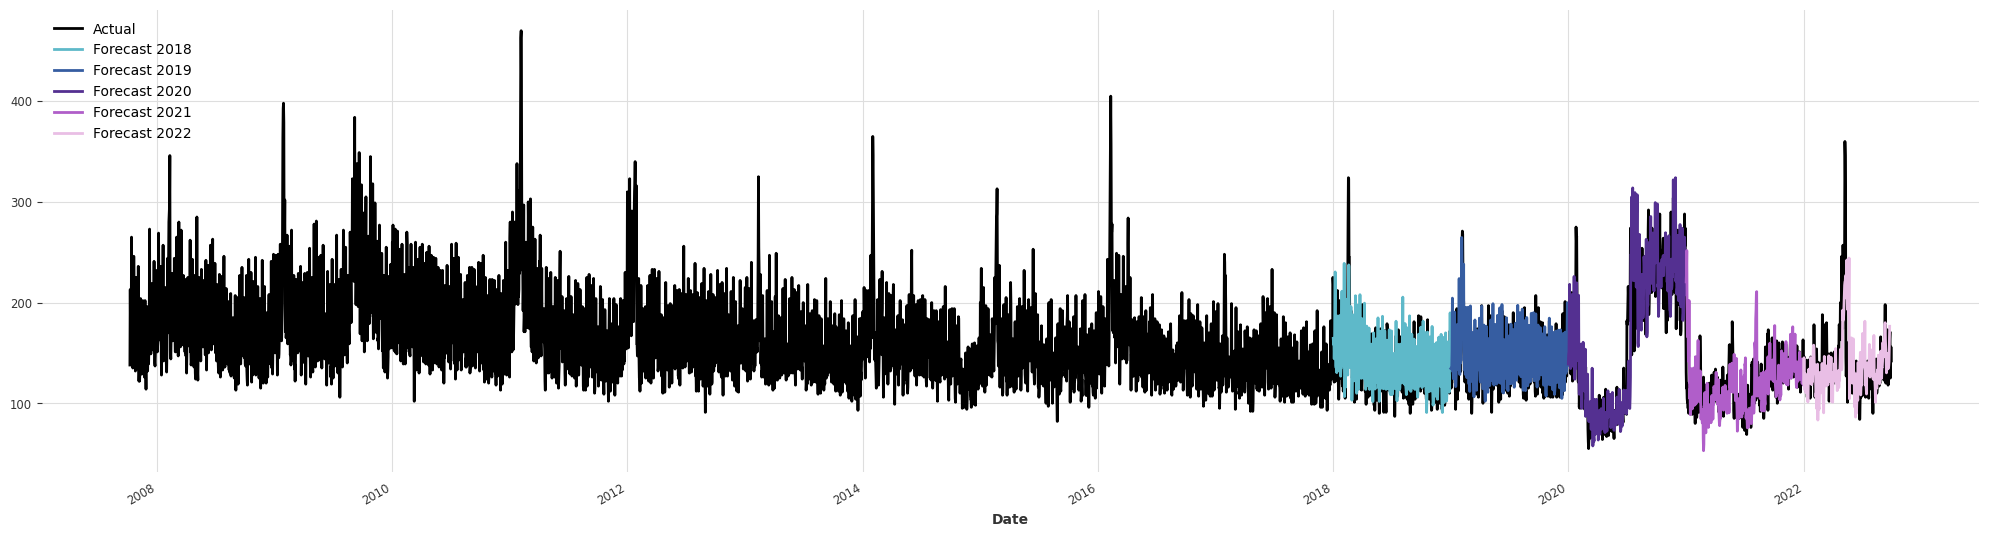

In [15]:
plt.figure(figsize=(25, 6))

# 绘制实际数据
combined_series.plot(label="Actual", color='black')

# 为2018到2022年的每个年份绘制预测数据
colors = ['#5EB9C9', '#365DA1', '#543091', '#B05EC9', '#E9BEE5']   # 为每个年份指定一个颜色
for i, year in enumerate(range(2018, 2023)):
    # 将DataArray转换回TimeSeries以便使用plot方法
    # 注意：这里假设yearly_dataarrays中存储的是DataArray对象
    ts = TimeSeries.from_xarray(yearly_dataarrays[year])
    
    # 绘制每年的预测数据
    ts.plot(label=f"Forecast {year}", color=colors[i])

# 添加图例
plt.legend()

# 显示图表
plt.show()

#Save prediction

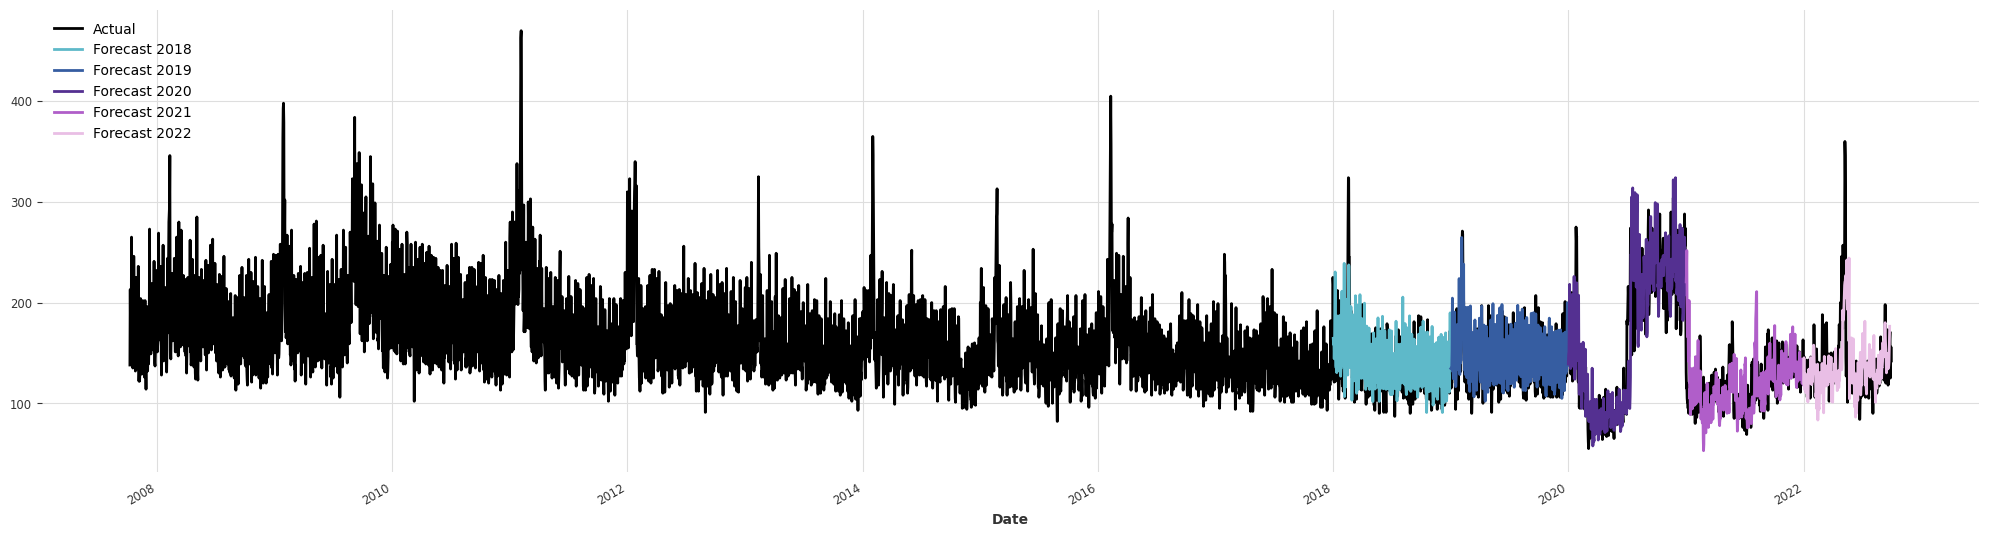

Forecast plot saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\TiDE\Taipei\Taipei_TiDE_FH7_forecast_plot.png
Metrics saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\TiDE\Taipei\Taipei_TiDE_FH7_metrics.txt
Model_prediction_df_inverse saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\TiDE\Taipei\Taipei_TiDE_FH7.csv


In [17]:
forecast_horizon_label = f"FH{forecast_horizon}"

# Define paths for the result files, using 'FH30' in the filenames
base_dir = os.path.abspath(os.path.join('..', 'Result', model_type, location))
plot_path = os.path.join(base_dir, f'{location}_{model_type}_{forecast_horizon_label}_forecast_plot.png')
metrics_txt_path = os.path.join(base_dir, f'{location}_{model_type}_{forecast_horizon_label}_metrics.txt')

# Ensure that the directories exist
os.makedirs(base_dir, exist_ok=True)

# Plot the actual and forecast data
plt.figure(figsize=(25, 6))

# Plot the actual data
combined_series.plot(label="Actual", color='black')

# Plot forecast data for each year (2018-2022)
colors = ['#5EB9C9', '#365DA1', '#543091', '#B05EC9', '#E9BEE5']
for i, year in enumerate(range(2018, 2023)):
    ts = TimeSeries.from_xarray(yearly_dataarrays[year])  # Convert DataArray to TimeSeries
    ts.plot(label=f"Forecast {year}", color=colors[i])

# Add legend
plt.legend()

# Save the plot to the specified path BEFORE displaying it
plt.savefig(plot_path, bbox_inches='tight')

# Now display the plot
plt.show()

# Print confirmation
print(f"Forecast plot saved to {plot_path}")

# Calculate metrics and save them
metrics_result = calculate_metrics(combined_series, yearly_dataarrays, APEdf, calculate_95_ci)

if metrics_result is not None:
    with open(metrics_txt_path, 'w') as f:
        # Write location, model_type, and forecast_horizon each on a new line
        f.write(f"Location: {location}\n")
        f.write(f"Model: {model_type}\n")
        f.write(f"Forecast Horizon: {forecast_horizon_label}\n\n")
        
        # Write header with aligned columns
        f.write(f"{'Period':<25} | {'MAE':<8} | {'MAPE':<8} | {'APE 95% CI':<20}\n")
        f.write("-" * 65 + "\n")  # Separator line
        
        # Write each period's metrics in a single line, aligned
        for period, metric in metrics_result.items():
            if isinstance(metric['APE 95% CI'], tuple):
                f.write(f"{period:<25} | {metric['MAE']:<8.2f} | {metric['MAPE']:<7.2f}% | "
                        f"({metric['APE 95% CI'][0]:.2f}, {metric['APE 95% CI'][1]:.2f})\n")
            else:
                f.write(f"{period:<25} | {metric['MAE']:<8.2f} | {metric['MAPE']:<7.2f}% | "
                        f"APE 95% CI: N/A\n")
                
    print(f"Metrics saved to {metrics_txt_path}")
else:
    print("Metrics calculation returned None, so nothing was saved.")

# Save Model_prediction_df_inverse to CSV
csv_filename = f"{location}_{model_type}_{forecast_horizon_label}.csv"
csv_filepath = os.path.join(base_dir, csv_filename)
Model_prediction_df_inverse.to_csv(csv_filepath, index=True)

# Print confirmation
print(f"Model_prediction_df_inverse saved to {csv_filepath}")